In [1]:
##%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.animation import FuncAnimation
import os
from xmitgcm import open_mdsdataset
from xmitgcm.utils import get_grid_from_input, get_extra_metadata

from myutils import *
from MITgcmutils import llc
import xarray as xr
import cmocean.cm as cmo
#import cartopy.crs as ccrs
import cartopy as cart

def sq(a):
    import numpy as np
    a = np.squeeze(a)
    masked_array=np.ma.masked_where(a==0., a)
    return masked_array

def mosaic_llc(field):
    return np.vstack([np.hstack([np.vstack([np.rot90(field[i]) for i in [9,8,7]]),
                                 np.vstack([np.rot90(field[i]) for i in [12,11,10]]),
                                 np.vstack([field[i] for i in [0,1,2]]),
                                 np.vstack([field[i] for i in [3,4,5]])]),
                      np.hstack([np.rot90(field[6])*np.tri(90)[::-1,:],np.triu(np.rot90(field[6],k=2))*np.tri(90)[::-1,:],
                                 np.triu(np.rot90(field[6],k=-1)),np.zeros(field[6].shape)])])[30:315,:]

def llc13to5faces(field):
    """
    fld = llc13to5faces(field) returns a list of 5 faces constructed from 
    the input of a 13-faces field as returned from 
    xmitgcm.open_mdsdataset(...,geometry='llc')
    """
    return [np.vstack((field[0,...],field[1,...],field[2,...])),
            np.vstack((field[3,...],field[4,...],field[5,...])),
            field[6,...],
            np.hstack((field[7,...],field[8,...],field[9,...])),
            np.hstack((field[10,...],field[11,...],field[12,...]))]

def symNorm(vmax):
    import matplotlib.colors as mcolors
    return mcolors.Normalize(vmin=-vmax,vmax=vmax)

def flat2d(x):
    if type(x) is np.ndarray:
        x0 = np.concatenate( [np.concatenate([x[:,0,:,:],x[:,1,:,:],x[:,2,:,:]], axis=-2),
                              np.concatenate([x[:,3,:,:],x[:,4,:,:],x[:,5,:,:]], axis=-2)], axis=-1 )
        y0 = np.concatenate( [np.concatenate([x[:,7,:,:],x[:,8,:,:],x[:,9,:,:]], axis=-1),
                              np.concatenate([x[:,10,:,:],x[:,11,:,:],x[:,12,:,:]], axis=-1)], axis=-2 )
    else:
        x0 = xr.concat( [xr.concat( [x.isel(face=0),x.isel(face=1),x.isel(face=2)], dim = 'j' ),
                         xr.concat( [x.isel(face=3),x.isel(face=4),x.isel(face=5)], dim = 'j' )], dim='i' )
        y0 = xr.concat( [xr.concat( [x.isel(face=7),x.isel(face=8),x.isel(face=9)], dim = 'i' ),
                         xr.concat( [x.isel(face=10),x.isel(face=11),x.isel(face=12)], dim = 'i' )], dim='j' )
    return np.concatenate((x0,np.rot90(y0,k=1,axes=(-2,-1))), axis=-1)

def calc_drake_passage_transport(ds):
    vtrans = (ds.VVEL*ds.hFacS*ds.drF).sum('k')*ds.dxG * 1e-6
    return (vtrans.sel(face=11,i=range(87,90),j_g=62).sum('i') + vtrans.sel(face=12,i=range(20),j_g=62).sum('i'))

def make_masks(coords):
    global_mask = coords.hFacC.isel(k=0).where(coords.YC<70).fillna(0)
    atlantic_mask = coords.hFacC.isel(k=0).where(
        np.logical_and(coords.YC>-35,coords.YC<70)).where( # Southern Ocean and Arctic
        np.logical_and(coords.XC<20,coords.XC>-98)).where( # most of the non-Atlantic Ocean
        np.logical_or(coords.XC<0,np.logical_or(coords.YC<30,coords.YC>47))).where(
        np.logical_or(coords.XC<-9,np.logical_or(coords.YC<34,coords.YC>38))).where( # Strait of Gibraltar
        np.logical_or(coords.XC>-70,coords.YC>9)).where( # East Pacific 
        np.logical_or(coords.XC>-84,coords.YC>14)).where( # Isthmus of Panama etc.
        np.logical_or(coords.XC>-90,coords.YC>18)).where(
        np.logical_or(coords.XC>-70,coords.YC<50)).fillna(0)
    indopacific_mask = (global_mask-atlantic_mask).where(
        np.logical_and(coords.YC>-35,coords.YC<70)).fillna(0)
    # remove Hudson
    indopacific_mask[10,10:,:39] = 0.
    # remove Med and parts of Arctic
    indopacific_mask[ 2,20:,29:84] = 0.
    # remove Bering strait and Chukchy Sea
    indopacific_mask[ 7,:,:14] = 0.
    return global_mask, atlantic_mask, indopacific_mask

def zonal_mean(ds,fld,msk):
    # mask the Med
    dvol = flat2d(ds.hFacC*ds.rA*ds.drF*msk)
    # mask the Med
    dvol[:,200:217,33:80]=0
    dvol[:,217:222,40:60]=0
    ra = dvol.sum(axis=-1)
    ra[ra==0]=np.Inf
    fldz = (flat2d(fld)*dvol).sum(axis=-1)/ra
    return np.ma.masked_array(fldz,fldz==0)

def compute_moc(wflux):
    u0 = xr.concat( [xr.concat( [wflux.isel(face=0),wflux.isel(face=1),wflux.isel(face=2)], dim = 'j' ),
                     xr.concat( [wflux.isel(face=3),wflux.isel(face=4),wflux.isel(face=5)], dim = 'j' )], dim='i' )
    v0 = xr.concat( [xr.concat( [wflux.isel(face=7),wflux.isel(face=8),wflux.isel(face=9)], dim = 'i' ),
                     xr.concat( [wflux.isel(face=10),wflux.isel(face=11),wflux.isel(face=12)], dim = 'i' )], dim='j' )
    wflx = (np.concatenate((u0,np.rot90(v0,k=1,axes=(-2,-1))), axis=-1)).sum(axis=-1)
    # order of integration: from north to south because of Atlantic MOC, requires sign change
    mocstrf = -np.flip(np.flip(wflx,axis=-1).cumsum(axis=-1),axis=-1)
    mocstrf[wflx==0]=0.
    return mocstrf

def compute_moc_layers(dl,msk):

    locmsk = msk.values
    ufx = dl.LaUH1RHO*dl.dyG*locmsk
    vfx = dl.LaVH1RHO*dl.dxG*locmsk
    zzu = dl.LaHw1RHO*locmsk
    zzv = dl.LaHs1RHO*locmsk
    zzu = zzu.where(zzu>0.)
    zzv = zzv.where(zzv>0.)
    # integration over longitude
    vf =  xr.concat([vfx.isel(face= 0),vfx.isel(face= 1),vfx.isel(face= 2)],dim='j_g').sum(dim='i') \
        + xr.concat([vfx.isel(face= 3),vfx.isel(face= 4),vfx.isel(face= 5)],dim='j_g').sum(dim='i')
    uf =  xr.concat([ufx.isel(face= 7),ufx.isel(face= 8),ufx.isel(face= 9)],dim='i_g').sum(dim='j') \
        + xr.concat([ufx.isel(face=10),ufx.isel(face=11),ufx.isel(face=12)],dim='i_g').sum(dim='j')
    uvf = vf.data[:,1:]-uf.data[:,:0:-1]
    # average layer thickness over lontitude, making sure to not count the zeros
    zv = xr.concat([xr.concat([zzv.isel(face= 0),zzv.isel(face= 1),zzv.isel(face= 2)],dim='j_g'),
                    xr.concat([zzv.isel(face= 3),zzv.isel(face= 4),zzv.isel(face= 5)],dim='j_g')],
                        dim='i').mean(dim='i', skipna=True)
    zu = xr.concat([xr.concat([zzu.isel(face= 7),zzu.isel(face= 8),zzu.isel(face= 9)],dim='i_g'),
                    xr.concat([zzu.isel(face=10),zzu.isel(face=11),zzu.isel(face=12)],dim='i_g')],
                        dim='j').mean(dim='j', skipna=True)
    # at this point we have averaged over 2 times 2 faces, now we need
    # to average over these two averages after flipping the
    # coordinates and shifiting them.
    # complicated reordering because of xarray dataArrays
    zur = zu.rename({'i_g':'j_g'}).assign_coords(j_g=range(zu.shape[1]))
    zvr = zv.assign_coords(j_g=range(zv.shape[1]))
    zl = xr.concat([zvr.roll(j_g=1),
                    zur.reindex(j_g=zur.j_g[::-1])],
                   dim='ii').mean(dim='ii',skipna=True).fillna(0.)
    zl = - zl.cumsum(axis=0)
    # add a column of zeros at the southern end
    uvf = np.hstack((np.zeros((uvf.shape[0],1)),uvf))
    zl[:,0]=0.
    # integration over depth
    psi = np.cumsum(uvf,axis=0)

    return psi, zl

def plot2dmap(ax,fld,levs,tstr='dummy',cmap=None):
    
    ax.set_global()
    # for iface in [0,1,2,3,4,5,6,7,8,9,10,11,12]:
    # for iface in [0,1,2,3,4,5,10,11,12]:
    for iface in range(13):
        if iface==12: 
            clrbr=True
            # cbarargs={"orientation": "horizontal"}
            cbarargs={"extend": "both", "orientation": "horizontal"}
            if levs.vmin==0.: 
                cbarargs["extend"] = "max"
        else:
            clrbr=False
            cbarargs=None

        fld.isel(face=iface).plot.pcolormesh(ax=ax, transform=cart.crs.PlateCarree(), x="XC", y="YC", norm=levs,
                                             add_colorbar=clrbr, cmap=cmap, cbar_kwargs=cbarargs)
    
    ax.set_title('%s'%(tstr))
    ax.coastlines()
    ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
    ax.gridlines()
    
def colorbar(mappable, **plt_kwargs):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax, **plt_kwargs)
    plt.sca(last_axes)
    return cbar

In [2]:
# We generate the extra metadata needed for multi-faceted grids
llc90_extra_metadata = get_extra_metadata(domain='llc', nx=90)
grid = get_grid_from_input(os.path.join('/home/ollie/mlosch/MITgcm/nils/llc90/input','tile<NFACET>.mitgrid'),
                           geometry='llc', extra_metadata=llc90_extra_metadata)

In [8]:
deltat=1800.
ny, nx = 1170, 90
prefix=['diags2D','diags3D','diagsGGL90','diagsKrN2']
# prefix=['diagsKrN2']

prefixmonthly = ['diags2DMonthly']

bdir='/work/ollie/mlosch/idemix_test/llc90'
gdir='/work/ollie/mlosch/idemix_test/llc90/grid'
fdir='/home/ollie/mlosch/MITgcm/MITgcm/idemix_test/llc90/figs'
rdir0='/work/ollie/mlosch/idemix_test/llc90/run15' # like run01 with 60 days for salinity restoring, 10m/60days = 1.9290123456790124e-06 m/s)
rdir1='/work/ollie/mlosch/idemix_test/llc90/run17' # same as run03 with idemix, jayne-forcing

rname0='CTRL'
rname1='run17'

In [4]:
# find out the file numbers to read
cycle = 5
startyear = 1958
refdate = "%i-1-1 0:0:0"%(startyear-(cycle-1)*62)
mycycle = "cycle%i"%(cycle)

d00 = open_mdsdataset(rdir1,prefix=['diagsKrN2'],delta_t=deltat,ref_date=refdate,geometry='llc')
# fix coordinates
d00.coords['XC'] = grid.XC
d00.coords['YC'] = grid.YC
d00.coords['XG'] = grid.XG
d00.coords['YG'] = grid.YG
coords = d00.coords.to_dataset().reset_coords()

In [5]:
myiters=list(d00.iter.values)
print("available output slices %i, years %s to %s"%(len(myiters),
    d00.time[0].data.astype('datetime64[Y]'),d00.time[-1].data.astype('datetime64[Y]')))

available output slices 310, years 1710 to 1864


In [6]:
ds0 = open_mdsdataset(rdir0,prefix=prefix,iters=myiters,
                      delta_t=deltat,ref_date=refdate,geometry='llc') #,extra_metadata=llc90_extra_metadata)
# fix coordinates
ds0.coords['XC'] = grid.XC
ds0.coords['YC'] = grid.YC
ds0.coords['XG'] = grid.XG
ds0.coords['YG'] = grid.YG
ds0

<xarray.Dataset>
Dimensions:               (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_u: 50, k_l: 50, k_p1: 51, face: 13, l1_b: 89, l1_c: 88, l1_i: 87, time: 310)
Coordinates: (12/51)
  * i                     (i) int64 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88 89
  * i_g                   (i_g) int64 0 1 2 3 4 5 6 7 ... 83 84 85 86 87 88 89
  * j                     (j) int64 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88 89
  * j_g                   (j_g) int64 0 1 2 3 4 5 6 7 ... 83 84 85 86 87 88 89
  * k                     (k) int64 0 1 2 3 4 5 6 7 ... 42 43 44 45 46 47 48 49
  * k_u                   (k_u) int64 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
    ...                    ...
    dyU                   (face, j_g, i_g) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    layer_1RHO_bounds     (l1_b) >f4 dask.array<chunksize=(89,), meta=np.ndarray>
    layer_1RHO_center     (l1_c) float32 dask.array<chunksize=(88,), meta=np.ndarray>
    layer_1RHO_interface  (l1_i) >f4 dask.array<chunksize=(87,), meta=np.ndarray>
    iter                  (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time                  (time) datetime64[ns] 1710-07-02T12:00:00 ... 1864-...
Data variables: (12/18)
    GGL90KN2              (time, k_l, face, j, i) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    THETA                 (time, k, face, j, i) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    SALT                  (time, k, face, j, i) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    DRHODR                (time, k_l, face, j, i) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    UVEL                  (time, k, face, j, i_g) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    VVEL                  (time, k, face, j_g, i) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    ...                    ...
    GGL90TKE              (time, k_l, face, j, i) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    GGL90Lmx              (time, k_l, face, j, i) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    GGL90Prl              (time, k_l, face, j, i) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    GGL90Kr               (time, k_l, face, j, i) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    GGL90ArU              (time, k_l, face, j, i) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    GGL90ArV              (time, k_l, face, j, i) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir=None, iters=No...

In [7]:
dl0 = open_mdsdataset(rdir0,prefix='diagsLAYERS', iters=myiters,
                      delta_t=deltat,ref_date=refdate,geometry='llc')
dl0.coords['XC'] = grid.XC
dl0.coords['YC'] = grid.YC
dl0.coords['XG'] = grid.XG
dl0.coords['YG'] = grid.YG

dl0

OSError: Could not find the expected file prefixes ['diagsLAYERS'] at iternum 8760. (Instead found [])

In [9]:
ds1 = open_mdsdataset(os.path.join(rdir1),prefix=prefix,iters=myiters,
                      delta_t=deltat,ref_date=refdate,geometry='llc')
# fix coordinates
ds1.coords['XC'] = grid.XC
ds1.coords['YC'] = grid.YC
ds1.coords['XG'] = grid.XG
ds1.coords['YG'] = grid.YG

ds1

<xarray.Dataset>
Dimensions:               (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_u: 50, k_l: 50, k_p1: 51, face: 13, l1_b: 89, l1_c: 88, l1_i: 87, time: 310)
Coordinates: (12/51)
  * i                     (i) int64 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88 89
  * i_g                   (i_g) int64 0 1 2 3 4 5 6 7 ... 83 84 85 86 87 88 89
  * j                     (j) int64 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88 89
  * j_g                   (j_g) int64 0 1 2 3 4 5 6 7 ... 83 84 85 86 87 88 89
  * k                     (k) int64 0 1 2 3 4 5 6 7 ... 42 43 44 45 46 47 48 49
  * k_u                   (k_u) int64 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
    ...                    ...
    dyU                   (face, j_g, i_g) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    layer_1RHO_bounds     (l1_b) >f4 dask.array<chunksize=(89,), meta=np.ndarray>
    layer_1RHO_center     (l1_c) float32 dask.array<chunksize=(88,), meta=np.ndarray>
    layer_1RHO_interface  (l1_i) >f4 dask.array<chunksize=(87,), meta=np.ndarray>
    iter                  (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time                  (time) datetime64[ns] 1710-07-02T12:00:00 ... 1864-...
Data variables: (12/18)
    GGL90KN2              (time, k_l, face, j, i) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    THETA                 (time, k, face, j, i) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    SALT                  (time, k, face, j, i) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    DRHODR                (time, k_l, face, j, i) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    UVEL                  (time, k, face, j, i_g) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    VVEL                  (time, k, face, j_g, i) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    ...                    ...
    GGL90TKE              (time, k_l, face, j, i) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    GGL90Lmx              (time, k_l, face, j, i) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    GGL90Prl              (time, k_l, face, j, i) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    GGL90Kr               (time, k_l, face, j, i) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    GGL90ArU              (time, k_l, face, j, i) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    GGL90ArV              (time, k_l, face, j, i) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir=None, iters=No...

In [10]:
dl1 = open_mdsdataset(rdir1,prefix='diagsLAYERS', iters=myiters,
                      delta_t=deltat,ref_date=refdate,geometry='llc')
dl1.coords['XC'] = grid.XC
dl1.coords['YC'] = grid.YC
dl1.coords['XG'] = grid.XG
dl1.coords['YG'] = grid.YG

dl1

OSError: Could not find the expected file prefixes ['diagsLAYERS'] at iternum 8760. (Instead found [])

In [ ]:
plt.close('all')
mytindex=ds1.time.shape[0]-1
mytime=ds1.time.isel(time=mytindex)
yearstr = str(ds0.time.sel(time=mytime).data.astype('datetime64[Y]'))

# select the last 40 years of the last (4th) cycle and compute the mean (to be kept in memory)

In [34]:
year0,year1 = '1980','2020'
yearstr = year1
do_compute=True
if do_compute:
    ds0m=ds0.sel(time=slice(year0,year1)).mean(dim='time').compute()
    ds1m=ds1.sel(time=slice(year0,year1)).mean(dim='time').compute()
# also for the layers output
    dm0=dl0.sel(time=slice(year0,year1)).mean(dim='time').compute()
    dm1=dl1.sel(time=slice(year0,year1)).mean(dim='time').compute()
    ds0m.to_netcdf("/work/ollie/mlosch/idemix_test/llc90/%s_%s.nc"%(rname0,mycycle))
    ds1m.to_netcdf("/work/ollie/mlosch/idemix_test/llc90/%s_%s.nc"%(rname1,mycycle))
    dm0.to_netcdf("/work/ollie/mlosch/idemix_test/llc90/%s_layers_%s.nc"%(rname0,mycycle))
    dm1.to_netcdf("/work/ollie/mlosch/idemix_test/llc90/%s_layers_%s.nc"%(rname1,mycycle))
else:
#     ds0m=ds0.sel(time=slice(year0,year1)).mean(dim='time')
#     ds1m=ds1.sel(time=slice(year0,year1)).mean(dim='time')
# # also for the layers output
#     dm0=dl0.sel(time=slice(year0,year1)).mean(dim='time')
#     dm1=dl1.sel(time=slice(year0,year1)).mean(dim='time')
    ds0m = xr.open_dataset("/work/ollie/mlosch/idemix_test/llc90/%s_%s.nc"%(rname0,mycycle))
    ds1m = xr.open_dataset("/work/ollie/mlosch/idemix_test/llc90/%s_%s.nc"%(rname1,mycycle))
    dm0  = xr.open_dataset("/work/ollie/mlosch/idemix_test/llc90/%s_layers_%s.nc"%(rname0,mycycle))
    dm1  = xr.open_dataset("/work/ollie/mlosch/idemix_test/llc90/%s_layers_%s.nc"%(rname1,mycycle))

In [12]:
if False:
    ds0m.to_netcdf("/work/ollie/mlosch/idemix_test/llc90/%s_%s.nc"%(rname0,mycycle))
    ds1m.to_netcdf("/work/ollie/mlosch/idemix_test/llc90/%s_%s.nc"%(rname1,mycycle))
    dm0.to_netcdf("/work/ollie/mlosch/idemix_test/llc90/%s_layers_%s.nc"%(rname0,mycycle))
    dm1.to_netcdf("/work/ollie/mlosch/idemix_test/llc90/%s_layers_%s.nc"%(rname1,mycycle))

# 2D maps of T/S K, N2 at 1000 m, 2000 m, 3000 m, 4000 m

In [14]:
import pyresample

class LLCMapper:

    def __init__(self, ds, dx=0.25, dy=0.25):
        # Extract LLC 2D coordinates
        lons_1d = ds.XC.values.ravel()
        lats_1d = ds.YC.values.ravel()

        # Define original grid
        self.orig_grid = pyresample.geometry.SwathDefinition(lons=lons_1d, lats=lats_1d)

        # Longitudes latitudes to which we will we interpolate
        lon_tmp = np.arange(-180, 180, dx) + dx/2
        lat_tmp = np.arange(-90, 90, dy) + dy/2

        # Define the lat lon points of the two parts.
        self.new_grid_lon, self.new_grid_lat = np.meshgrid(lon_tmp, lat_tmp)
        self.new_grid  = pyresample.geometry.GridDefinition(lons=self.new_grid_lon,
                                                            lats=self.new_grid_lat)

    def __call__(self, da, ax=None, lon_0=-60, tstr=None, **plt_kwargs):

        assert set(da.dims) == set(['face', 'j', 'i']), "da must have dimensions ['face', 'j', 'i']"

        field = pyresample.kd_tree.resample_nearest(self.orig_grid, da.values,
                                                    self.new_grid,
                                                    radius_of_influence=100000,
                                                    fill_value=None)

        x,y = self.new_grid_lon, self.new_grid_lat

        p = ax.pcolormesh(x, y, field, transform=cart.crs.PlateCarree(), **plt_kwargs)


        # ax.coastlines()
        # ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
        ax.add_feature(cart.feature.LAND, facecolor='0.7', zorder=3)
        ax.gridlines()

        if tstr is not None:
            ax.set_title('%s'%(tstr))
            
        label = None
        # if da.name is not None:
        #     label = da.name
        # if 'units' in da.attrs:
        #     label += ' (%s)' % da.attrs['units']
        cbarextend='both'
        try:
            mynorm = plt_kwargs.pop('norm')
            if mynorm.vmin == 0.: cbarextend='max'
        except:
            cbarextend='both'

        shrinkfac=1.
        cb = plt.colorbar(p, ax=ax, shrink=shrinkfac, label=label, extend=cbarextend, orientation='horizontal')

        return ax

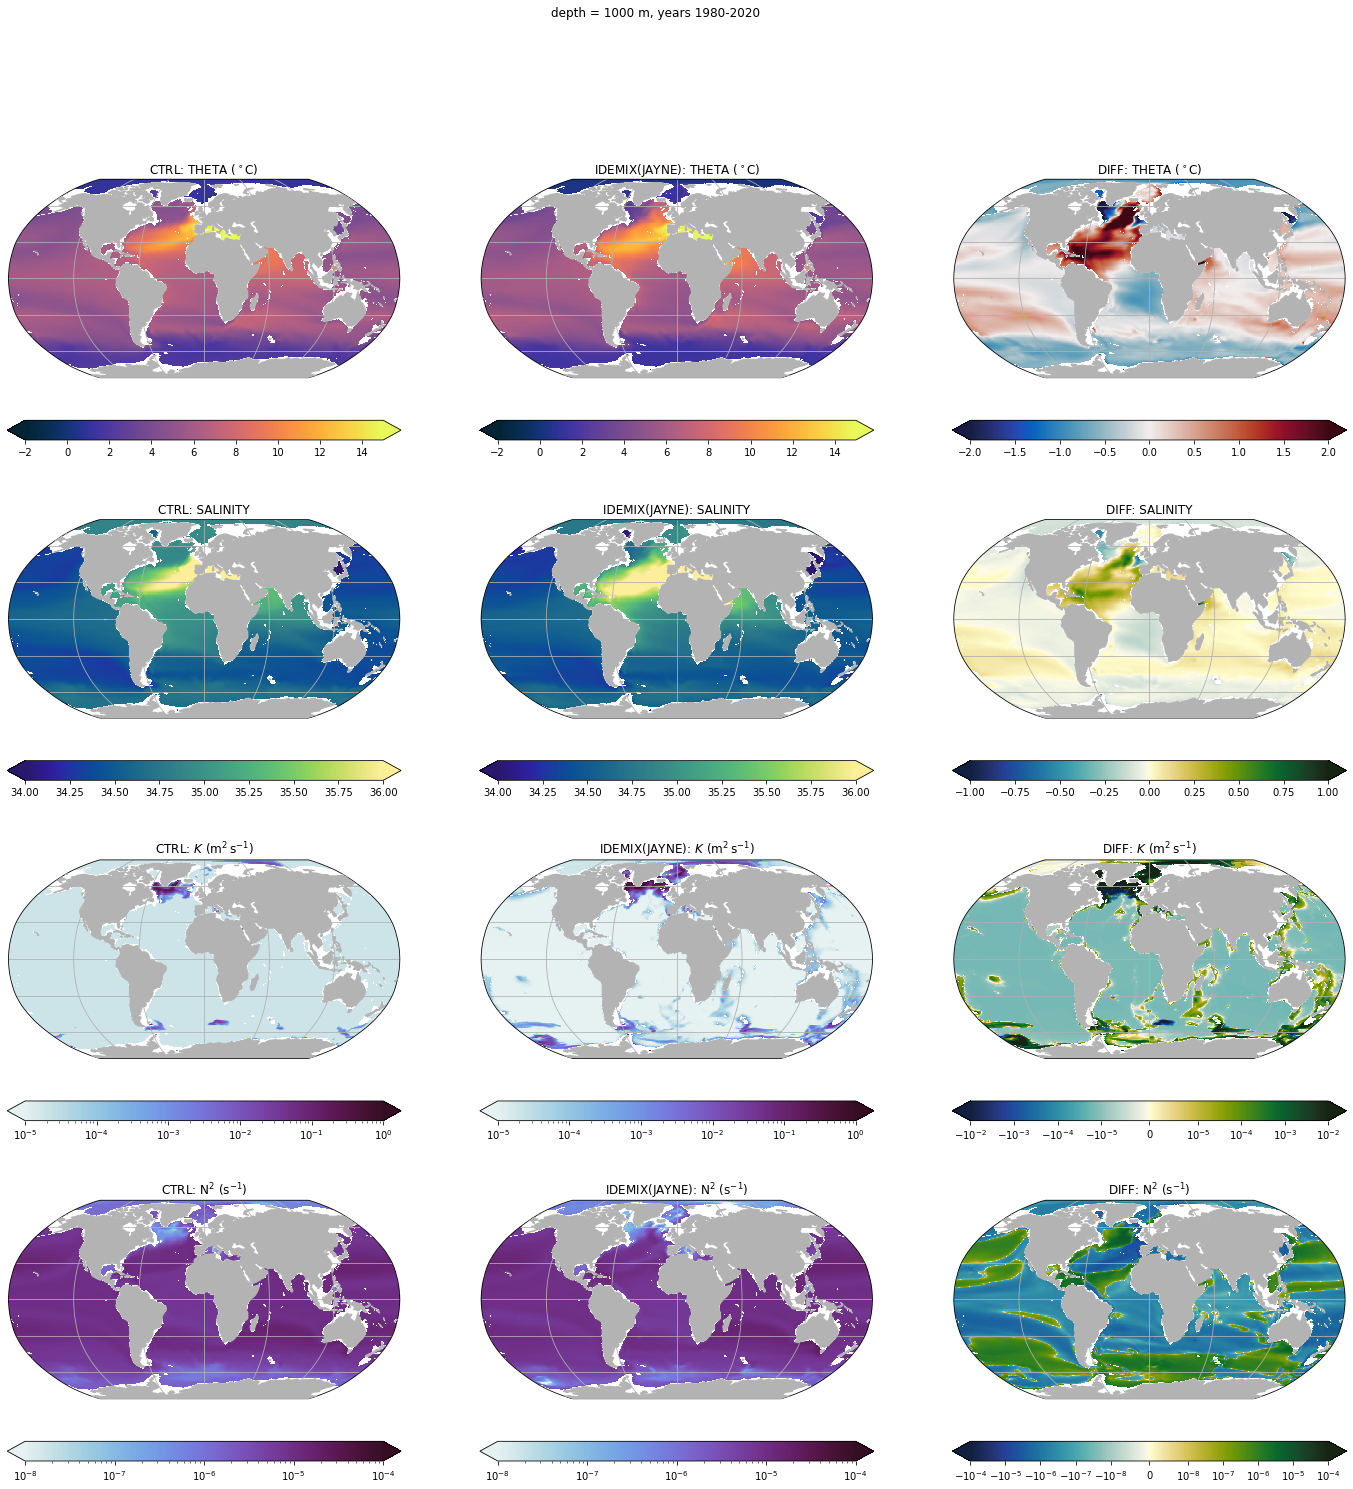

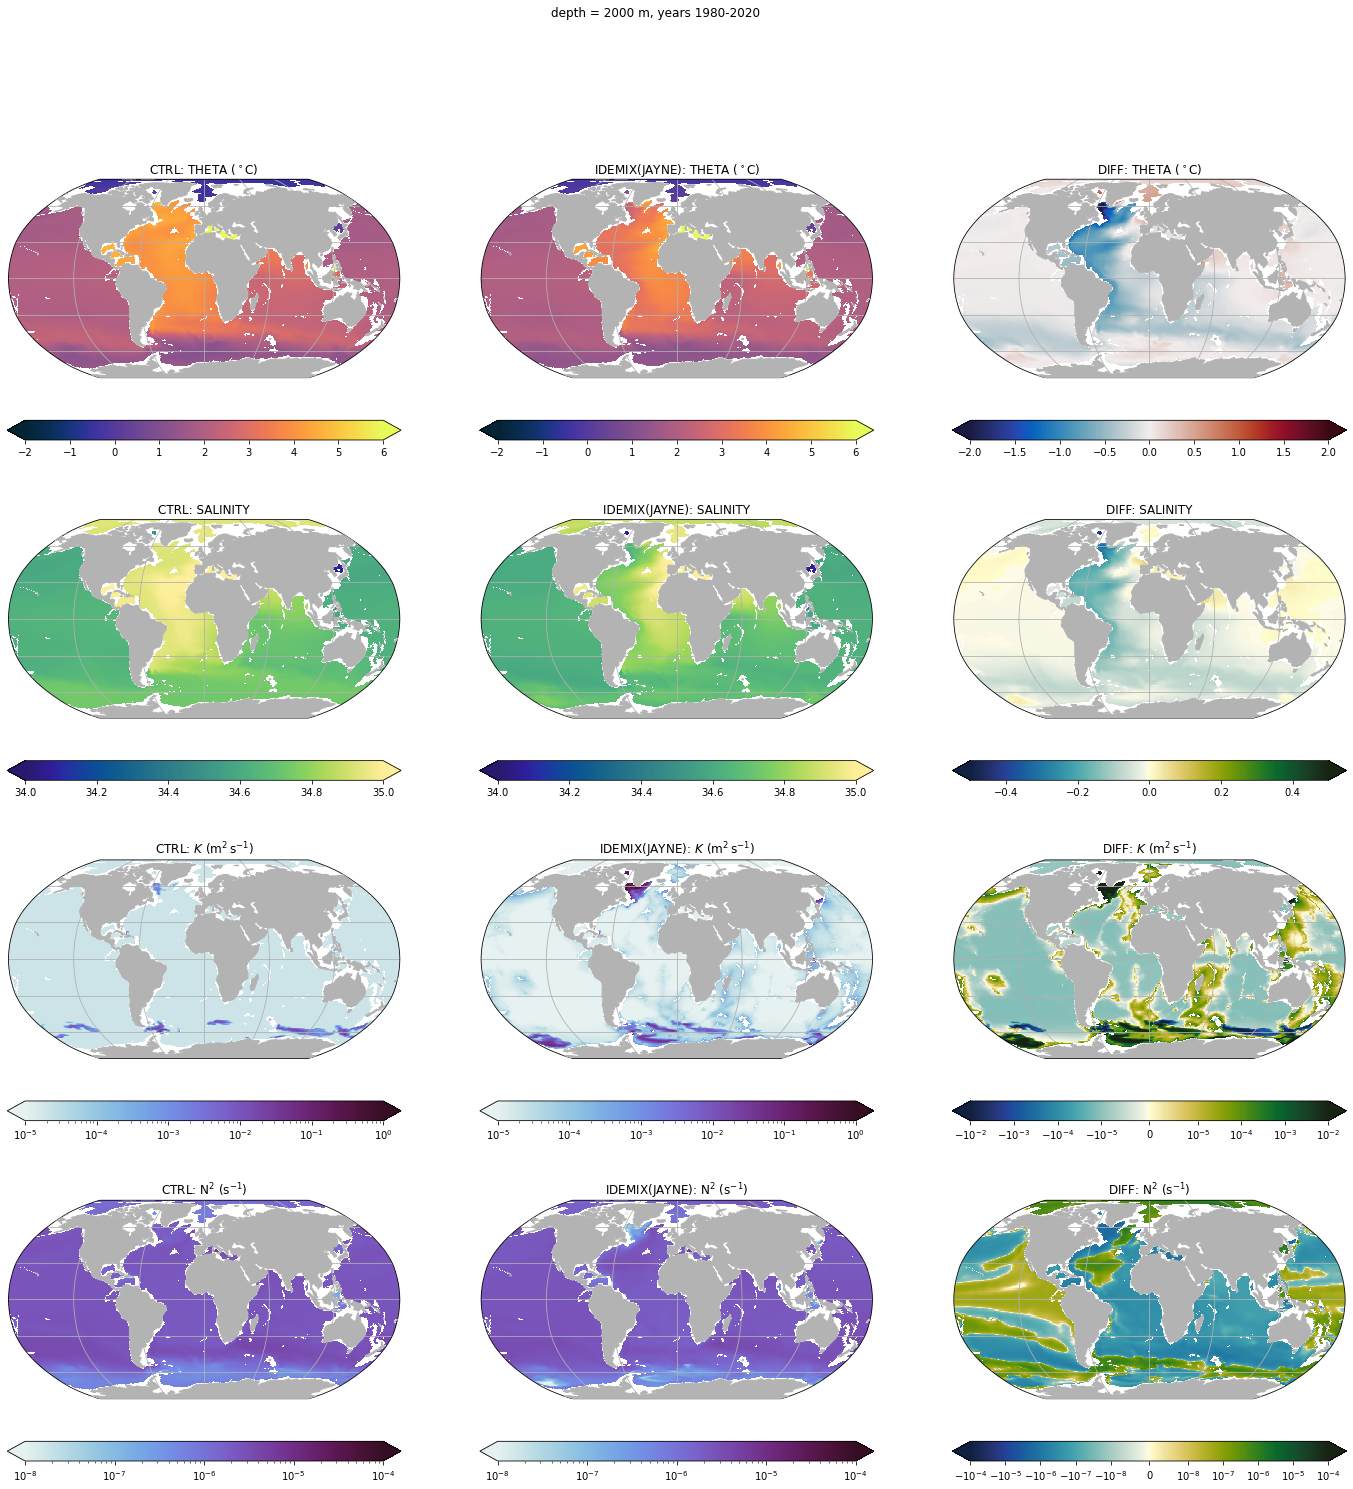

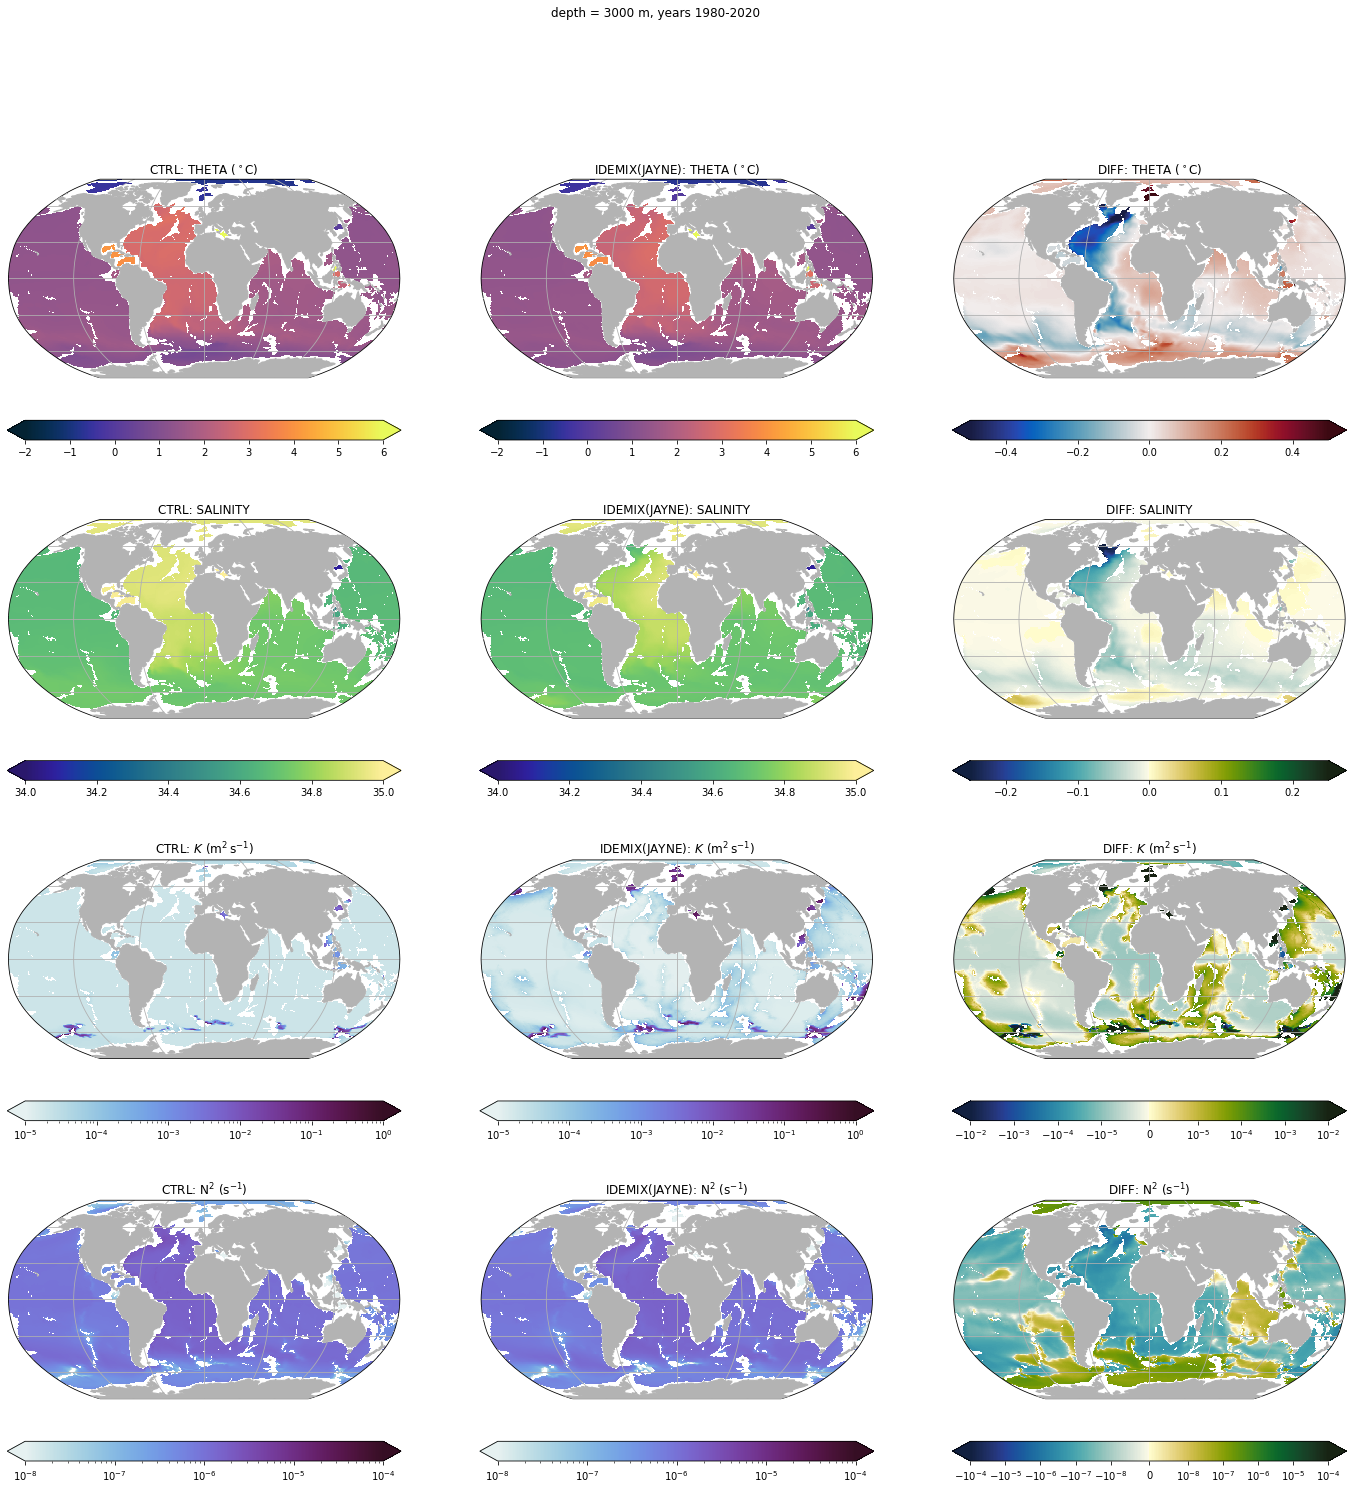

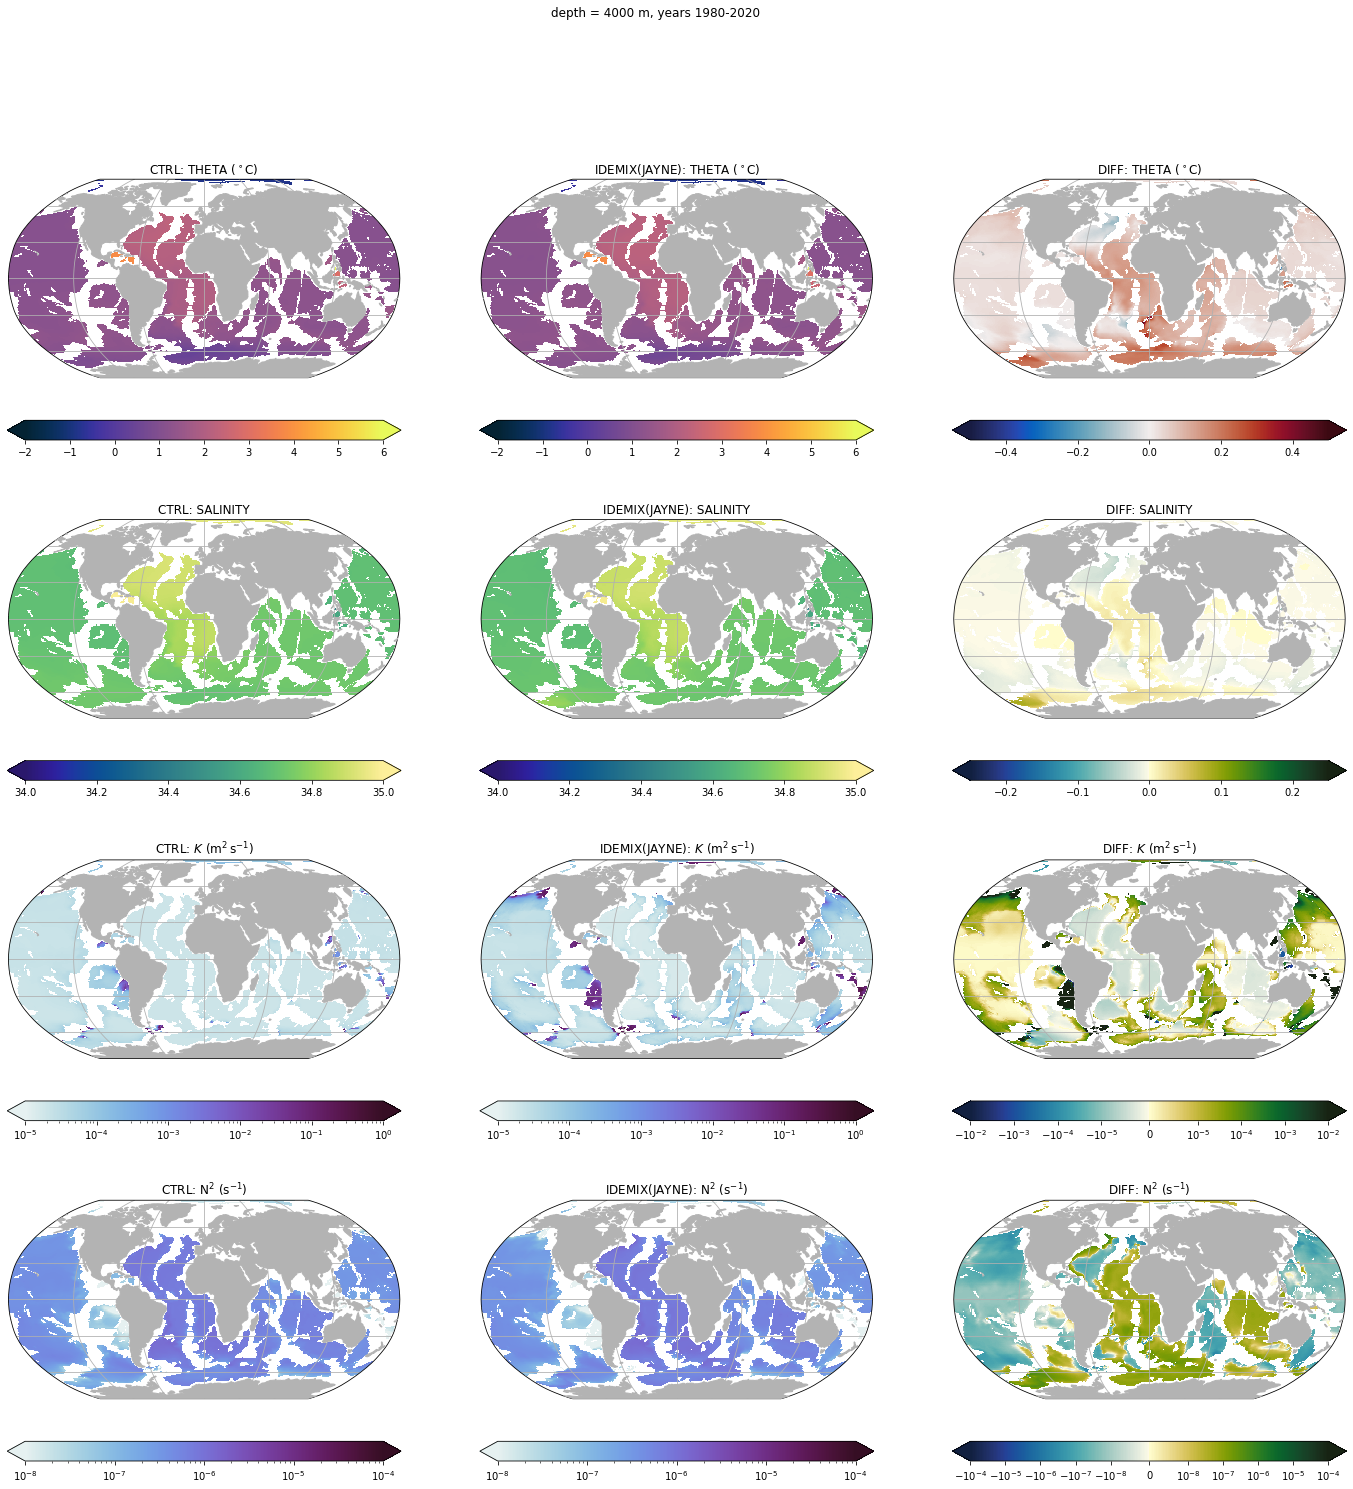

In [15]:
gr = 9.81/1035
proj=cart.crs.Robinson()#central_longitude=180.0-19) #central_longitude=7.0)
#proj=cart.crs.PlateCarree() #central_longitude=161.)

gr = 9.81/1035

dd = ds1m-ds0m
mask2d=ds0m.hFacC.isel(k=0)

tmax = [15., 6., 6., 6.]
smax = [36.,35.,35.,35.]
dt =  [2. ,2., 0.5, 0.5 ]
ds =  [1. ,0.5,0.25,0.25]

for kd, depth in enumerate([1000,2000,3000,4000]):
    
    k = ((ds0.Z+depth)**2).argmin().values
    mask2d=ds0.hFacC.isel(k=k)

    # create instance of LLC-mapper
    mapper = LLCMapper(coords) #, dx=1., dy=1.)

    fig, ax = plt.subplots(nrows=4,ncols=3,sharex=True,sharey=True,figsize=(24,24),subplot_kw={'projection': proj})
    # fig, ax = plt.subplots(nrows=1,ncols=1,sharex=True,sharey=True,figsize=(24,24),subplot_kw={'projection': proj})

    tnorm = colors.Normalize(vmin=-2,vmax=tmax[kd])
    mapper(ds0m.THETA.sel(k=k).where(mask2d!=0.),ax=ax[0,0],norm=tnorm,          cmap=cmo.thermal,tstr=rname0+': THETA ($^\circ$C)')
    mapper(ds1m.THETA.sel(k=k).where(mask2d!=0.),ax=ax[0,1],norm=tnorm,          cmap=cmo.thermal,tstr=rname1+': THETA ($^\circ$C)')
    mapper(  dd.THETA.sel(k=k).where(mask2d!=0.),ax=ax[0,2],norm=symNorm(dt[kd]),cmap=cmo.balance,tstr=   'DIFF: THETA ($^\circ$C)')
    # 
    snorm=colors.Normalize(vmin=34,vmax=smax[kd])
    mapper(ds0m.SALT.sel(k=k).where(mask2d!=0.),ax=ax[1,0],norm=snorm,          cmap=cmo.haline,tstr=rname0+': SALINITY')
    mapper(ds1m.SALT.sel(k=k).where(mask2d!=0.),ax=ax[1,1],norm=snorm,          cmap=cmo.haline,tstr=rname1+': SALINITY')
    mapper(  dd.SALT.sel(k=k).where(mask2d!=0.),ax=ax[1,2],norm=symNorm(ds[kd]),cmap=cmo.delta, tstr=   'DIFF: SALINITY')
    # 
    knorm=colors.LogNorm(vmin=1e-5,vmax=1.)
    mapper(ds0m.GGL90Kr.sel(k_l=k).where(mask2d!=0.),ax=ax[2,0],norm=knorm,cmap=cmo.dense,tstr=rname0+': $K$ (m$^{2}\,$s$^{-1}$)')
    mapper(ds1m.GGL90Kr.sel(k_l=k).where(mask2d!=0.),ax=ax[2,1],norm=knorm,cmap=cmo.dense,tstr=rname1+': $K$ (m$^{2}\,$s$^{-1}$)')
    dnorm=colors.SymLogNorm(linthresh=1e-5, linscale=1,vmin=-1.e-2,vmax=1.e-2)                                                                                                                                
    mapper(  dd.GGL90Kr.sel(k_l=k).where(mask2d!=0.),ax=ax[2,2],norm=dnorm,cmap=cmo.delta,tstr=   'DIFF: $K$ (m$^{2}\,$s$^{-1}$)')
    #
    nnorm=colors.LogNorm(vmin=1e-8,vmax=1.e-4)
    mapper(-gr*ds0m.DRHODR.sel(k_l=k).where(mask2d!=0.),ax=ax[3,0],norm=nnorm,cmap=cmo.dense,tstr=rname0+': N$^2$ (s$^{-1}$)')
    mapper(-gr*ds1m.DRHODR.sel(k_l=k).where(mask2d!=0.),ax=ax[3,1],norm=nnorm,cmap=cmo.dense,tstr=rname1+': N$^2$ (s$^{-1}$)')
    dnorm=colors.SymLogNorm(linthresh=1e-8, linscale=1,vmin=-1.e-4,vmax=1.e-4)
    mapper(-gr*  dd.DRHODR.sel(k_l=k).where(mask2d!=0.),ax=ax[3,2],norm=dnorm,cmap=cmo.delta,tstr=   'DIFF: N$^2$ (s$^{-1}$)')

    
    # y0,y1 = d00.time.isel(time=0),d00.time.isel(time=-1)
    # fig.suptitle('depth = %i m, years %s-%s'%(depth,y0.data.astype('datetime64[Y]'),y1.data.astype('datetime64[Y]')))
    fig.suptitle('depth = %i m, years %s-%s'%(depth,year0,year1))
    fig.savefig(os.path.join(fdir,'%s_%im_y%s'%('map2d',depth,yearstr)),dpi=300)


In [16]:
# overturning circulation

In [17]:
def plotmoc(ax,ds,msk,tstr='dummy'):
    mocstrf = compute_moc(ds.WVEL*(ds.rA*msk)*1e-6)
    # # wflx = flat2d(wflux).sum(axis=-1) # somehow, this does not work, so we spell it out:
    # u0 = xr.concat( [xr.concat( [wflux.isel(face=0),wflux.isel(face=1),wflux.isel(face=2)], dim = 'j' ),
    #                  xr.concat( [wflux.isel(face=3),wflux.isel(face=4),wflux.isel(face=5)], dim = 'j' )], dim='i' )
    # v0 = xr.concat( [xr.concat( [wflux.isel(face=7),wflux.isel(face=8),wflux.isel(face=9)], dim = 'i' ),
    #                  xr.concat( [wflux.isel(face=10),wflux.isel(face=11),wflux.isel(face=12)], dim = 'i' )], dim='j' )
    # wflx = (np.concatenate((u0,np.rot90(v0,k=1,axes=(-2,-1))), axis=-1)).sum(axis=-1)
    # # print(wflx.shape)
    # # order of integration: from north to south because of Atlantic MOC, require sign change
    # mocstrf = -np.flip(np.flip(wflx,axis=-1).cumsum(axis=-1),axis=-1)
    # mocstrf[wflx==0]=0.
    yy = flat2d(grid.YC)
    dd = flat2d(ds.Depth*msk)
    d = dd.max(axis=-1)
    y = yy.mean(axis=-1)
    #y = np.arange(y.shape[0])
    #csf=ax.pcolormesh(y,ds.Zu,sq(mocstrf),norm=symNorm(20),cmap=cmo.curl)#,vmin=-20,vmax=20)
    csf=ax.contourf(y,ds.Zu,sq(mocstrf),levels=np.linspace(-20,20,41),cmap=cmo.curl, extend='both')
    ax.fill_between(y,-d,-ds.drF.sum()-200,step='mid',facecolor='lightgrey')
    plt.colorbar(csf,ax=ax,orientation='horizontal',extend='both')
    ax.set_title('%s'%(tstr))
    plt.axis('tight')
    plt.grid()

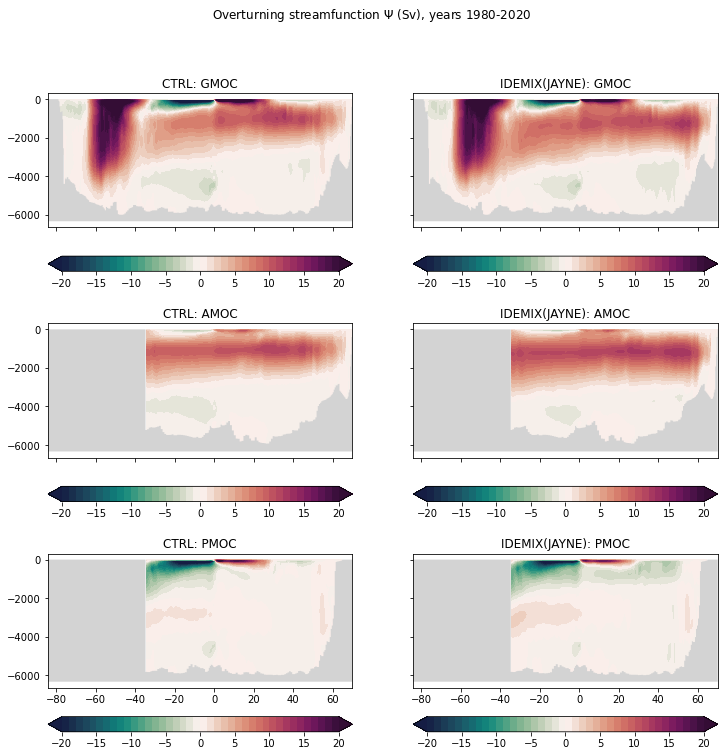

In [18]:
global_mask, atlantic_mask, indopacific_mask = make_masks(coords)
fig, ax = plt.subplots(nrows=3,ncols=2,sharex=True,sharey=True,figsize=(12,12))#, subplot_kw={'projection': proj})
plotmoc(ax[0,0],ds0m,global_mask,tstr=rname0+': GMOC')
plotmoc(ax[0,1],ds1m,global_mask,tstr=rname1+': GMOC')
plotmoc(ax[1,0],ds0m,atlantic_mask,tstr=rname0+': AMOC')
plotmoc(ax[1,1],ds1m,atlantic_mask,tstr=rname1+': AMOC')
plotmoc(ax[2,0],ds0m,indopacific_mask,tstr=rname0+': PMOC')
plotmoc(ax[2,1],ds1m,indopacific_mask,tstr=rname1+': PMOC')

y0,y1 = dl0.time.isel(time=0),dl0.time.isel(time=-1)
fig.suptitle('Overturning streamfunction $\Psi$ (Sv), years %s-%s'%(year0,year1))
fig.savefig(os.path.join(fdir,'%s_%s'%('moc',yearstr)),dpi=300)

In [36]:
def plotmoc_layers(ax,ds,msk,tstr='dummy'):
    mocstrf, zlayer = compute_moc_layers(ds,msk)
    dd = flat2d(ds.Depth*msk)
    d = dd.max(axis=-1)
    y = xr.concat([coords.YG.isel(face= 0),coords.YG.isel(face= 1),coords.YG.isel(face= 2)], dim='j_g').mean(dim='i_g')
    csf=ax.contourf(y,ds.layer_1RHO_interface,sq(mocstrf[:-1,:])*1e-6,levels=np.linspace(-20,20,41),cmap=cmo.curl, extend='both')
    # ax.invert_yaxis()
    ax.set_ylim(ds.layer_1RHO_interface.max(),ds.layer_1RHO_interface.min())
    plt.colorbar(csf,ax=ax,orientation='horizontal',extend='both')
    ax.set_title('%s'%(tstr))
    plt.axis('tight')
    plt.grid()

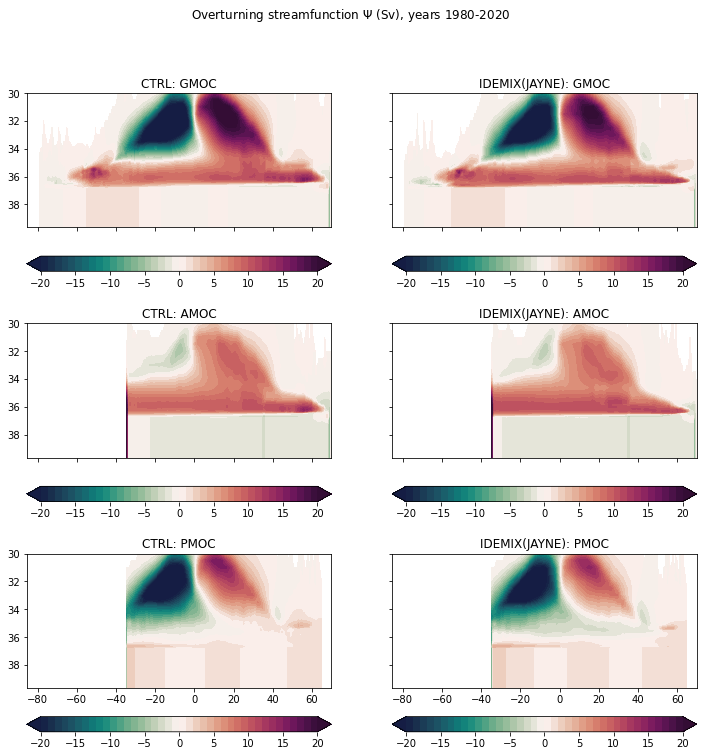

In [37]:
# y0,y1='2144', '2169'
# yearstr=y1
global_mask, atlantic_mask, indopacific_mask = make_masks(coords)

fig, ax = plt.subplots(nrows=3,ncols=2,sharex=True,sharey=True,figsize=(12,12))#, subplot_kw={'projection': proj})
# compute the time mean once and keep it in memory because we need it 3 times (and 3 more times for plotting the remapped values)
# dm0=dl0.sel(time=slice(y0,y1)).mean(dim='time').compute()
# dm1=dl1.sel(time=slice(y0,y1)).mean(dim='time').compute()
plotmoc_layers(ax[0,0],dm0,global_mask,tstr=rname0+': GMOC')
plotmoc_layers(ax[0,1],dm1,global_mask,tstr=rname1+': GMOC')
plotmoc_layers(ax[1,0],dm0,atlantic_mask,tstr=rname0+': AMOC')
plotmoc_layers(ax[1,1],dm1,atlantic_mask,tstr=rname1+': AMOC')
plotmoc_layers(ax[2,0],dm0,indopacific_mask,tstr=rname0+': PMOC')
plotmoc_layers(ax[2,1],dm1,indopacific_mask,tstr=rname1+': PMOC')

# y0,y1 = dl0.time.isel(time=0),dl0.time.isel(time=-1)
# fig.suptitle('Overturning streamfunction $\Psi$ (Sv), years %s-%s'%(y0.data.astype('datetime64[Y]'),y1.data.astype('datetime64[Y]')))
fig.suptitle('Overturning streamfunction $\Psi$ (Sv), years %s-%s'%(year0,year1))
fig.savefig(os.path.join(fdir,'%s_%s'%('moc_layers',yearstr)),dpi=300)

In [38]:
def plotmoc_remapped(ax,ds,msk,tstr='dummy'):
    mocstrf, zlayer = compute_moc_layers(ds,msk)
    dd = flat2d(ds.Depth*msk)
    d = dd.max(axis=-1)
    y = xr.concat([coords.YG.isel(face= 0),coords.YG.isel(face= 1),coords.YG.isel(face= 2)], dim='j_g').mean(dim='i_g')
    nl = ds.layer_1RHO_center.shape[0]
    yl = np.tile(y.data.reshape((1,y.shape[0])),(nl,1))
    csf=ax.contourf(yl,zlayer,sq(mocstrf)*1e-6,levels=np.linspace(-20,20,41),cmap=cmo.curl, extend='both')
    ax.fill_between(y,-d,-ds.drF.sum()-200,step='mid',facecolor='lightgrey')
    plt.colorbar(csf,ax=ax,orientation='horizontal',extend='both')
    ax.set_title('%s'%(tstr))
    plt.axis('tight')
    plt.grid()
    

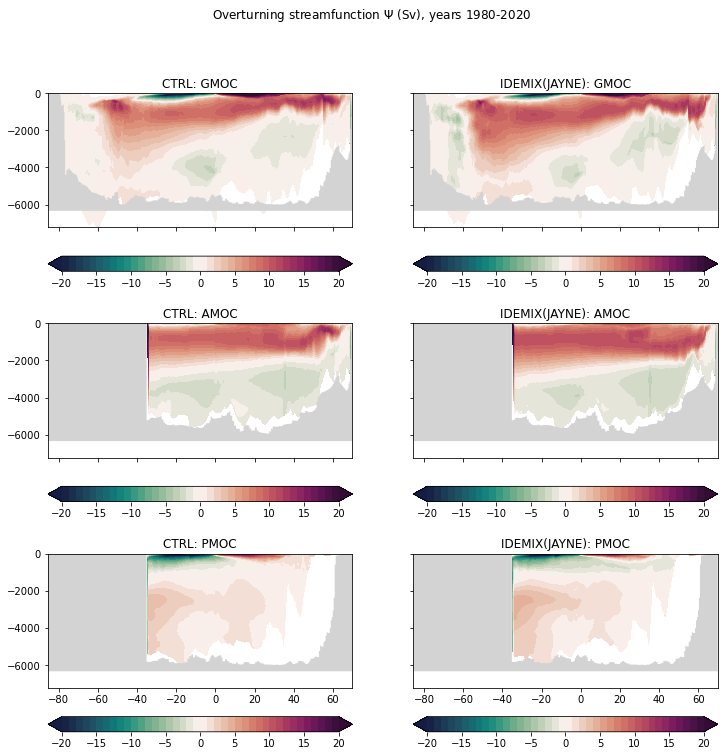

In [39]:
global_mask, atlantic_mask, indopacific_mask = make_masks(coords)

fig, ax = plt.subplots(nrows=3,ncols=2,sharex=True,sharey=True,figsize=(12,12))#, subplot_kw={'projection': proj})
# # compute the time mean once and keep it in memory because we need it 3 times
# dm0=dl0.sel(time=slice(y0,y1)).mean(dim='time').compute()
# dm1=dl1.sel(time=slice(y0,y1)).mean(dim='time').compute()
plotmoc_remapped(ax[0,0],dm0,global_mask,tstr=rname0+': GMOC')
plotmoc_remapped(ax[0,1],dm1,global_mask,tstr=rname1+': GMOC')
plotmoc_remapped(ax[1,0],dm0,atlantic_mask,tstr=rname0+': AMOC')
plotmoc_remapped(ax[1,1],dm1,atlantic_mask,tstr=rname1+': AMOC')
plotmoc_remapped(ax[2,0],dm0,indopacific_mask,tstr=rname0+': PMOC')
plotmoc_remapped(ax[2,1],dm1,indopacific_mask,tstr=rname1+': PMOC')

#y0,y1 = dl0.time.isel(time=0),dl0.time.isel(time=-1)
#fig.suptitle('Overturning streamfunction $\Psi$ (Sv), years %s-%s'%(y0.data.astype('datetime64[Y]'),y1.data.astype('datetime64[Y]')))
fig.suptitle('Overturning streamfunction $\Psi$ (Sv), years %s-%s'%(year0,year1))
fig.savefig(os.path.join(fdir,'%s_%s'%('moc_remapped',yearstr)),dpi=300)

In [22]:
# dl=dl0.mean(dim='time')

# ufx = (dl.LaUH1RHO*dl.dyG).compute()
# vfx = (dl.LaVH1RHO*dl.dxG).compute()
# zzu = (dl.LaHw1RHO).compute()
# zzv = (dl.LaHs1RHO).compute()


# zonally averated salinity/temperature/$\kappa$/$N^2$/$\kappa\,N^2$

In [11]:
#plt.close('all')
import matplotlib.ticker as mtick
#mytindex = ds1.time.shape[0]-1

def format_func(x,pos):
    mystr = "%1.0e"%x
    return mystr

def plotzonalmean(ax,ds,fld,levs,msk=1.,tstr='dummy',cmap=None):
    # compute zonal mean along grid lines for now:
    y = flat2d(grid.YC).mean(axis=-1)
    fld0 = zonal_mean(ds,fld,msk)
    d = flat2d(ds.Depth*msk).max(axis=-1)
    if 'k_l' in fld.dims:
        # in this case we assume that we want to plot logarithmic color scales
        z = ds.Zl
        tickformat=mtick.LogFormatter()
        useLog=True
        if levs[0]>0:
            cnorm = colors.LogNorm(levs[0],levs[-1])
        else:
            # special trick, when logarithmic levels are negative use symmetric log scale
            cnorm = colors.SymLogNorm(linthresh=np.abs(levs[0]), linscale=2,
                                      vmin=-np.abs(levs[-1]),vmax=np.abs(levs[-1]))        
            levs = np.hstack((np.flip(levs),-levs))
            # cnorm = colors.Normalize(vmin=-np.abs(levs[-1]),vmax=np.abs(levs[-1]))        
            tickformat=mtick.FuncFormatter(format_func)
    else:
        z = ds.Z
        useLog=False
        cnorm = None
    csf=ax.contourf(y,z,fld0,levels=levs,norm=cnorm,extend='both',cmap=cmap)
    ax.contour(y,z,fld0,levels=levs,colors='gray',linewidths=0.25)
    ax.fill_between(y,-d,-ds.Depth.max()-200.,step='mid',facecolor='lightgrey')
    if useLog:
        plt.colorbar(csf,ax=ax,orientation='horizontal',format=tickformat)
    else:
        plt.colorbar(csf,ax=ax,orientation='horizontal')
    ax.set_title('%s'%(tstr))

NameError: name 'year0' is not defined

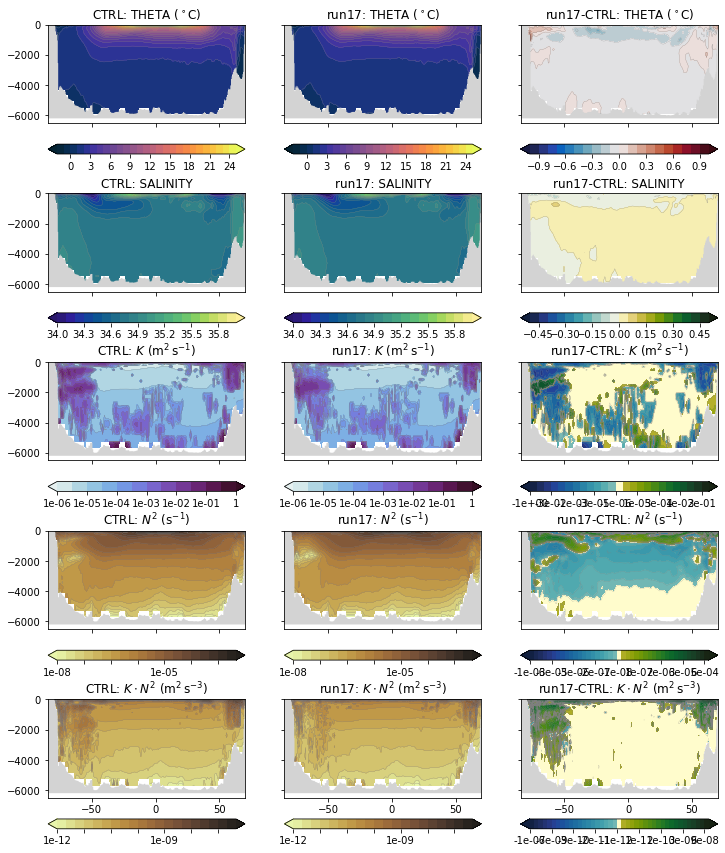

In [16]:
#ds1m=ds1.isel(time=-1)
#ds0m=ds0.isel(time=-1)
dd = ds1m-ds0m
# N2 = - gravity/rho0 * DRHODR 
gr = 9.81/1035

global_mask, atlantic_mask, indopacific_mask = make_masks(coords)

fig,ax=plt.subplots(5,3,figsize=(12,15),sharex=True,sharey=True);
#
plotzonalmean(ax[0,0],ds0m,ds0m.THETA,np.linspace(-2,25,28),global_mask,  '%s: THETA ($^\circ$C)'%rname0,cmap=cmo.thermal)
plotzonalmean(ax[0,1],ds1m,ds1m.THETA,np.linspace(-2,25,28),global_mask,  '%s: THETA ($^\circ$C)'%rname1,cmap=cmo.thermal)
plotzonalmean(ax[0,2],ds0m,  dd.THETA,np.linspace(-1,1,21), global_mask,'%s-%s: THETA ($^\circ$C)'%(rname1,rname0),cmap=cmo.balance)
#
plotzonalmean(ax[1,0],ds0m,ds0m.SALT, np.linspace(34,36,21),global_mask,    '%s: SALINITY'%rname0,cmap=cmo.haline)
plotzonalmean(ax[1,1],ds1m,ds1m.SALT, np.linspace(34,36,21),global_mask,    '%s: SALINITY'%rname1,cmap=cmo.haline)
plotzonalmean(ax[1,2],ds0m,  dd.SALT, np.linspace(-.5,.5,21),global_mask,'%s-%s: SALINITY'%(rname1,rname0),cmap=cmo.delta)
#
knorm = np.logspace(-6,0,13)
plotzonalmean(ax[2,0],ds0m,ds0m.GGL90Kr, knorm,global_mask,    '%s: $K$ (m$^{2}\,$s$^{-1}$)'%rname0,cmap=cmo.dense)
plotzonalmean(ax[2,1],ds1m,ds1m.GGL90Kr, knorm,global_mask,    '%s: $K$ (m$^{2}\,$s$^{-1}$)'%rname1,cmap=cmo.dense)
plotzonalmean(ax[2,2],ds1m,  dd.GGL90Kr,-knorm,global_mask,'%s-%s: $K$ (m$^{2}\,$s$^{-1}$)'%(rname1,rname0),cmap=cmo.delta)
#
rnorm = np.logspace(-8,-3,21)
plotzonalmean(ax[3,0],ds0m,abs(-gr*ds0m.DRHODR),rnorm,global_mask,   '%s: $N^2$ (s$^{-1}$)'%rname0,cmap=cmo.turbid)
plotzonalmean(ax[3,1],ds1m,abs(-gr*ds1m.DRHODR),rnorm,global_mask,   '%s: $N^2$ (s$^{-1}$)'%rname1,cmap=cmo.turbid)
plotzonalmean(ax[3,2],ds0m,-gr*(dd.DRHODR),    -rnorm,global_mask,'%s-%s: $N^2$ (s$^{-1}$)'%(rname1,rname0),cmap=cmo.delta)
#
nnorm=np.logspace(-12,-7,21)
plotzonalmean(ax[4,0],ds0m,abs(ds0m.GGL90KN2),nnorm,global_mask,   '%s: $K\cdot N^2$ (m$^{2}\,$s$^{-3}$)'%rname0,cmap=cmo.turbid)
plotzonalmean(ax[4,1],ds1m,abs(ds1m.GGL90KN2),nnorm,global_mask,   '%s: $K\cdot N^2$ (m$^{2}\,$s$^{-3}$)'%rname1,cmap=cmo.turbid)
plotzonalmean(ax[4,2],ds0m,     dd.GGL90KN2 ,-nnorm,global_mask,'%s-%s: $K\cdot N^2$ (m$^{2}\,$s$^{-3}$)'%(rname1,rname0),cmap=cmo.delta)

#y0,y1 = d00.time.isel(time=0),d00.time.isel(time=-1)
#fig.suptitle('"zonal mean", years %s-%s'%(y0.data.astype('datetime64[Y]'),y1.data.astype('datetime64[Y]')))
fig.suptitle('"zonal mean", years %s-%s'%(year0,year1))
#fig.savefig(os.path.join(fdir,'%s_%s'%('zonal_mean',yearstr)),dpi=300)

# potential density

In [40]:
#plt.close(fig)
def plotzonalmeanp(ax,ds,fld,levs,msk=1.,tstr='dummy',cmap=None):
    # compute zonal mean along grid lines for now:
    y = flat2d(grid.YC).mean(axis=-1)
    fld0 = zonal_mean(ds,fld,msk)
    d = flat2d(ds.Depth*msk).max(axis=-1)
    z = ds.Z
    useLog=False
    cnorm = colors.Normalize(levs[0],vmax=levs[-1])
    csf=ax.pcolormesh(y,z,sq(fld0),norm=cnorm,cmap=cmap)
    ax.contour(y,z,fld0,levels=levs,colors='w',linewidths=0.25)
    ax.fill_between(y,-d,-ds.Depth.max()-200.,step='mid',facecolor='lightgrey')
    if useLog:
        plt.colorbar(csf,ax=ax,orientation='horizontal',format=tickformat)
    else:
        plt.colorbar(csf,ax=ax,orientation='horizontal')
    ax.set_title('%s'%(tstr))

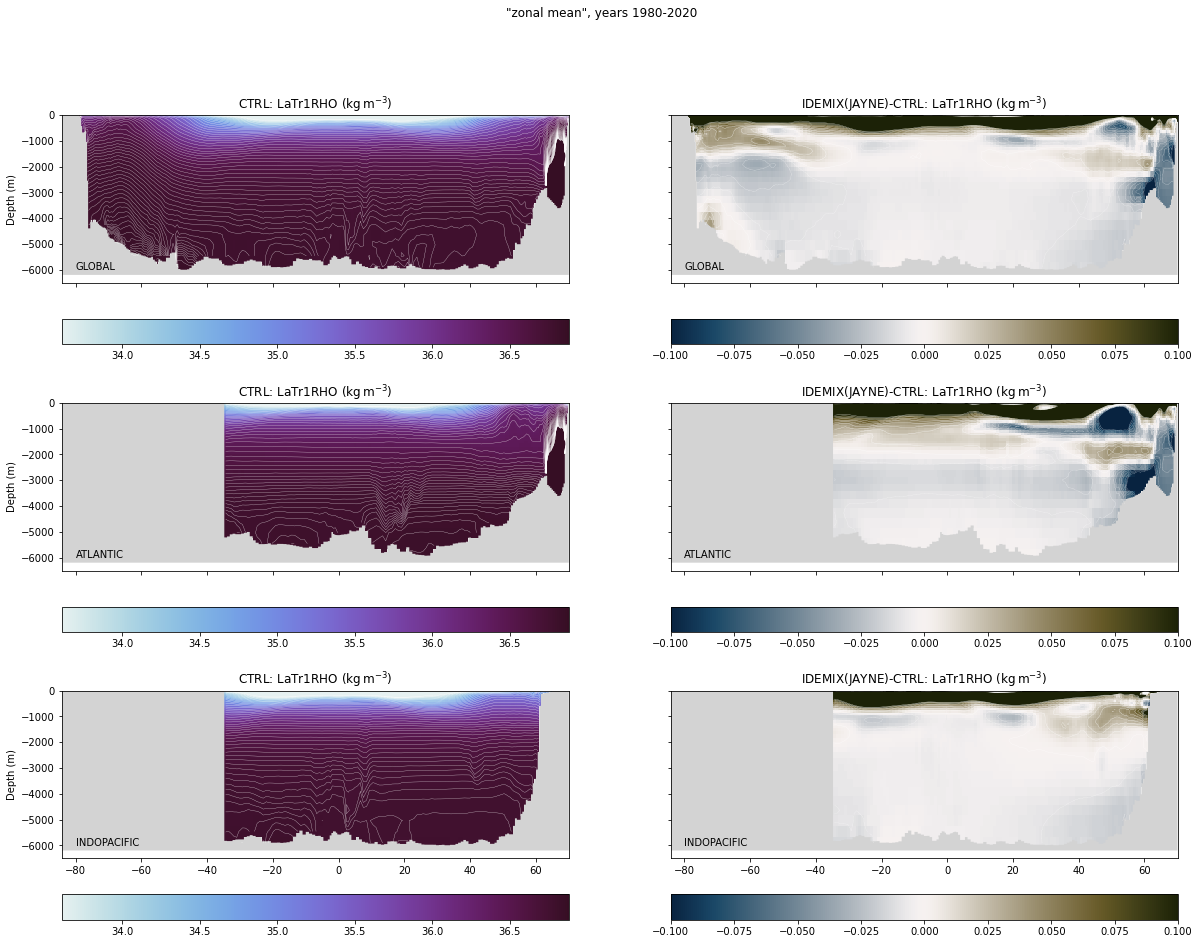

In [41]:
global_mask, atlantic_mask, indopacific_mask = make_masks(coords)

fig,ax=plt.subplots(3,2,figsize=(20,15),sharex=True,sharey=True);
# get density levels from dataset
#ds0m.layer_1RHO_bounds
dd = ds1m-ds0m
#
plotzonalmeanp(ax[0,0],ds0m,ds0m.LaTr1RHO,ds0m.layer_1RHO_interface[8:-8],global_mask,   '%s: LaTr1RHO (kg$\,$m$^{-3}$)'%rname0,cmap=cmo.dense)
# plotzonalmeanp(ax[0,1],ds1m,ds1m.LaTr1RHO,ds1m.layer_1RHO_bounds,global_mask, '%s: LaTr1RHO (kg$\,$m$^{-3}$)'%rname1,cmap=cmo.dense)
plotzonalmeanp(ax[0,1],ds0m,  dd.LaTr1RHO,         np.linspace(-.1,.1,21),global_mask,'%s-%s: LaTr1RHO (kg$\,$m$^{-3}$)'%(rname1,rname0),cmap=cmo.diff)
# 
plotzonalmeanp(ax[1,0],ds0m,ds0m.LaTr1RHO,ds0m.layer_1RHO_interface[8:-8],atlantic_mask,   '%s: LaTr1RHO (kg$\,$m$^{-3}$)'%rname0,cmap=cmo.dense)
# plotzonalmeanp(ax[1,1],ds1m,ds1m.LaTr1RHO,ds1m.layer_1RHO_bounds,atlantic_mask,  '%s: LaTr1RHO (kg$\,$m$^{-3}$)'%rname1,cmap=cmo.dense)
plotzonalmeanp(ax[1,1],ds0m,  dd.LaTr1RHO,       np.linspace(-.1,.1,21),  atlantic_mask,'%s-%s: LaTr1RHO (kg$\,$m$^{-3}$)'%(rname1,rname0),cmap=cmo.diff)
#
plotzonalmeanp(ax[2,0],ds0m,ds0m.LaTr1RHO,ds0m.layer_1RHO_interface[8:-8],indopacific_mask,   '%s: LaTr1RHO (kg$\,$m$^{-3}$)'%rname0,cmap=cmo.dense)
# plotzonalmeanp(ax[2,1],ds1m,ds1m.LaTr1RHO,ds1m.layer_1RHO_bounds,indopacific_mask,  '%s: LaTr1RHO (kg$\,$m$^{-3}$)'%rname1,cmap=cmo.dense)
plotzonalmeanp(ax[2,1],ds0m,  dd.LaTr1RHO,       np.linspace(-.1,.1,21),  indopacific_mask,'%s-%s: LaTr1RHO (kg$\,$m$^{-3}$)'%(rname1,rname0),cmap=cmo.diff)

for b in ax[:,0]: b.set_ylabel('Depth (m)')
for b in ax[0,:]: b.text(-80,-6000,'GLOBAL')
for b in ax[1,:]: b.text(-80,-6000,'ATLANTIC')
for b in ax[2,:]: b.text(-80,-6000,'INDOPACIFIC')

# ax[1,2].set_ylabel('Atlantic')
# ax[1,2].yaxis.set_label_position('right')
#

fig.suptitle('"zonal mean", years %s-%s'%(year0,year1))
fig.savefig(os.path.join(fdir,'%s_%s'%('density_zonal_mean',yearstr)),dpi=300)

compute density from theta/salt/pressure

Text(0.5, 0.98, '"zonal mean", years 1980-2020')

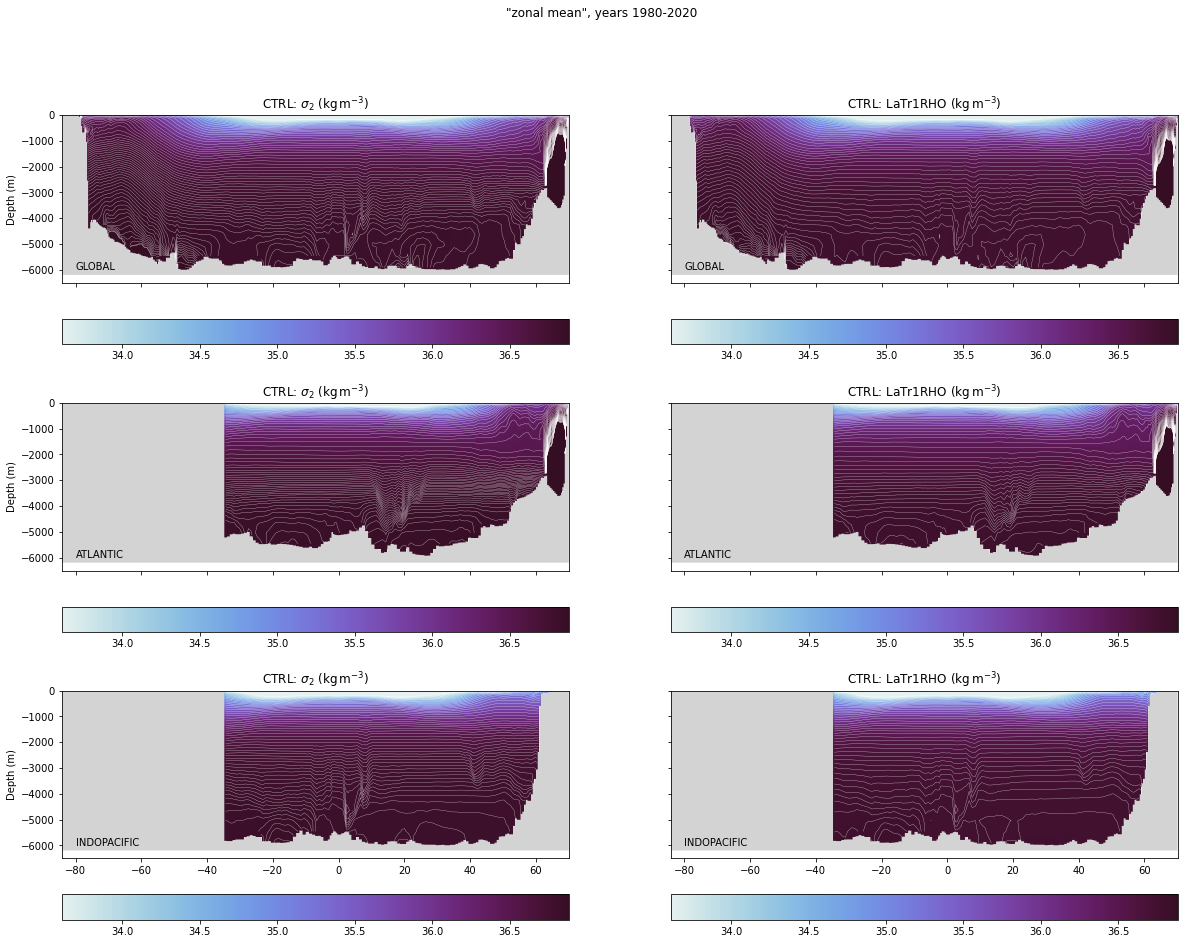

In [42]:
global_mask, atlantic_mask, indopacific_mask = make_masks(coords)

import seawater as sw

def sig2(ds):
    import seawater as sw
    pref = 2084*9.81*1035*1e-4
    pref = 1914*9.81*1035*1e-4
    return sw.dens(ds.SALT,ds.THETA,pref)-1000.

fig,ax=plt.subplots(3,2,figsize=(20,15),sharex=True,sharey=True);
# get density levels from dataset
#ds0m.layer_1RHO_bounds
# from compute density
dd = ds1m-ds0m
#
plotzonalmeanp(ax[0,0],ds0m,sig2(ds0m),   ds0m.layer_1RHO_interface[8:-8],global_mask, '%s: $\sigma_2$ (kg$\,$m$^{-3}$)'%rname0,cmap=cmo.dense)
plotzonalmeanp(ax[0,1],ds0m,ds0m.LaTr1RHO,ds1m.layer_1RHO_interface[8:-8],global_mask, '%s: LaTr1RHO (kg$\,$m$^{-3}$)'%rname0,cmap=cmo.dense)
# plotzonalmeanp(ax[0,1],ds0m,  dd.LaTr1RHO,         np.linspace(-.1,.1,21),global_mask,'%s-%s: LaTr1RHO (kg$\,$m$^{-3}$)'%(rname1,rname0),cmap=cmo.diff)
# 
plotzonalmeanp(ax[1,0],ds0m,sig2(ds0m),   ds0m.layer_1RHO_interface[8:-8],atlantic_mask,  '%s: $\sigma_2$ (kg$\,$m$^{-3}$)'%rname0,cmap=cmo.dense)
plotzonalmeanp(ax[1,1],ds0m,ds0m.LaTr1RHO,ds0m.layer_1RHO_interface[8:-8],atlantic_mask,  '%s: LaTr1RHO (kg$\,$m$^{-3}$)'%rname0,cmap=cmo.dense)
# plotzonalmeanp(ax[1,1],ds0m,  dd.LaTr1RHO,       np.linspace(-.1,.1,21),  atlantic_mask,'%s-%s: LaTr1RHO (kg$\,$m$^{-3}$)'%(rname1,rname0),cmap=cmo.diff)
# #
plotzonalmeanp(ax[2,0],ds0m,sig2(ds0m),   ds0m.layer_1RHO_interface[8:-8],indopacific_mask,   '%s: $\sigma_2$ (kg$\,$m$^{-3}$)'%rname0,cmap=cmo.dense)
plotzonalmeanp(ax[2,1],ds0m,ds0m.LaTr1RHO,ds0m.layer_1RHO_interface[8:-8],indopacific_mask,   '%s: LaTr1RHO (kg$\,$m$^{-3}$)'%rname0,cmap=cmo.dense)
# plotzonalmeanp(ax[2,1],ds0m,  dd.LaTr1RHO,       np.linspace(-.1,.1,21),  indopacific_mask,'%s-%s: LaTr1RHO (kg$\,$m$^{-3}$)'%(rname1,rname0),cmap=cmo.diff)

for b in ax[:,0]: b.set_ylabel('Depth (m)')
for b in ax[0,:]: b.text(-80,-6000,'GLOBAL')
for b in ax[1,:]: b.text(-80,-6000,'ATLANTIC')
for b in ax[2,:]: b.text(-80,-6000,'INDOPACIFIC')

# ax[1,2].set_ylabel('Atlantic')
# ax[1,2].yaxis.set_label_position('right')
#

fig.suptitle('"zonal mean", years %s-%s'%(year0,year1))
# fig.savefig(os.path.join(fdir,'%s_%s'%('density_zonal_mean',yearstr)),dpi=300)

# time series of overtuning circulation and Drake Passage transport
compute transports: for this we need to load the entire data set

In [6]:
import dask
#dask.config.set({"array.slicing.split_large_chunks": True})
mychunks={"time":62,"k_u":50,"k_l":50,"k":50,"face":13,"j":1170,"j_g":1170,"i":90,"i_g":90}
mychunks={"k_u":50,"k_l":50,"k":50,"face":13,"j":1170,"j_g":1170,"i":90,"i_g":90}
mychunks='auto'
dst0 = open_mdsdataset(rdir0,prefix=['diags3D'],delta_t=deltat,ref_date=refdate,geometry='llc') #,llc_method='bigchunks')
dst1 = open_mdsdataset(rdir1,prefix=['diags3D'],delta_t=deltat,ref_date=refdate,geometry='llc') #,chunks='auto')

In [9]:
global_mask, atlantic_mask, indopacific_mask = make_masks(coords)

mocstrf0 = compute_moc(dst0.WVEL*(dst0.rA*atlantic_mask)*1e-6)
mocstrf1 = compute_moc(dst1.WVEL*(dst1.rA*atlantic_mask)*1e-6)

In [15]:
dp0 = calc_drake_passage_transport(dst0).values
dp1 = calc_drake_passage_transport(dst1).values

In [18]:
do_compute=True
if do_compute:
    mocstrf0.tofile("/work/ollie/mlosch/idemix_test/llc90/mocstrf_%s.bin"%(rname0))
    mocstrf1.tofile("/work/ollie/mlosch/idemix_test/llc90/mocstrf_%s.bin"%(rname1))
    dp0.tofile("/work/ollie/mlosch/idemix_test/llc90/drake_passage_transp_%s.bin"%(rname0))
    dp1.tofile("/work/ollie/mlosch/idemix_test/llc90/drake_passage_transp_%s.bin"%(rname0))
else:
    pass

#ll = calc_drake_passage_transport(dst0)
#dst0.isel(time=0).WVEL.values #iter[range(310)].values
#ttt=open_mdsdataset(rdir0,prefix=['diags3D'],delta_t=deltat,ref_date=refdate,geometry='llc',iters=17520)
#ttt.VVEL.values
#iters=list(dst0.iter.values)
#iters
mocstrf1.shape

(310, 50, 270)

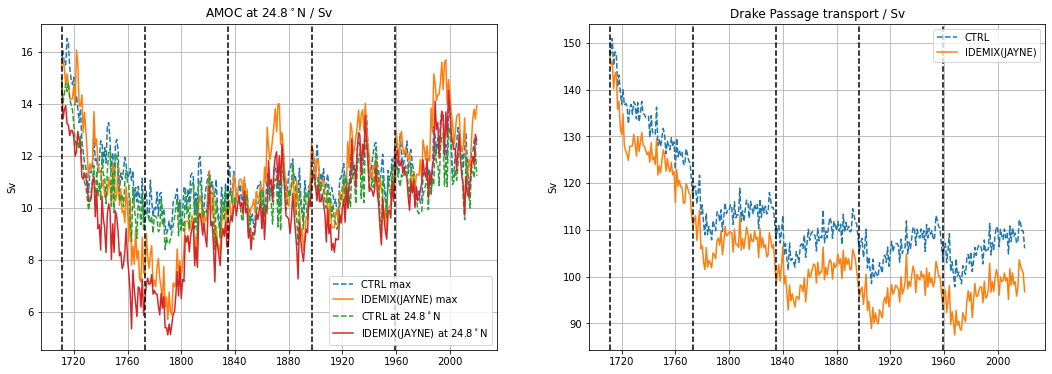

In [22]:
fig, ax = plt.subplots(nrows=1,ncols=2,sharex=True,figsize=(18,6))
#plt.clf()
y = flat2d(grid.YC).mean(axis=-1)
iz = 22 # blow 500m
iy = 165 # northern hemisphere
ax[0].plot(dst0.time,mocstrf0[:,iz:,iy:].max(axis=1).max(axis=-1),'--',label="%s max"%(rname0))
ax[0].plot(dst1.time,mocstrf1[:,iz:,iy:].max(axis=1).max(axis=-1),'-', label="%s max"%(rname1))

for iy in [195]:
    ax[0].plot(dst0.time,mocstrf0[:,iz:,iy].max(axis=1),'--',label="%s at %4.1f$^\circ$N"%(rname0,y[iy]))
    ax[0].plot(dst1.time,mocstrf1[:,iz:,iy].max(axis=1),'-', label="%s at %4.1f$^\circ$N"%(rname1,y[iy]))

ax[0].set_ylabel('Sv')
ax[0].set_title('AMOC at %4.1f$^\circ$N / Sv'%y[iy])
ax[0].legend()
ax[0].grid()
#plt.colorbar()

ax[1].plot(dst0.time,dp0,'--',label="%s"%(rname0))
ax[1].plot(dst1.time,dp1,'-',label="%s"%(rname1))

ax[1].set_ylabel('Sv')
ax[1].set_title('Drake Passage transport / Sv')
ax[1].legend()
ax[1].grid()

for a in ax:
    for x in dst0.time[0::62]:
        a.axvline(x.data,linestyle='--',color='k')

fig.savefig(os.path.join(fdir,'amoc_timeseries'),dpi=300)

# monthly averages

In [36]:
prefixmonthly = ['diags2DMonthly']
dm0 = open_mdsdataset(rdir0,prefix=prefixmonthly,
                     delta_t=deltat,ref_date=refdate,geometry='llc')
# fix coordinates
dm0.coords['XC'] = grid.XC
dm0.coords['YC'] = grid.YC
dm0.coords['XG'] = grid.XG
dm0.coords['YG'] = grid.YG
dm0

<xarray.Dataset>
Dimensions:               (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_u: 50, k_l: 50, k_p1: 51, face: 13, l1_b: 89, l1_c: 88, l1_i: 87, time: 484)
Coordinates: (12/51)
  * i                     (i) int64 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88 89
  * i_g                   (i_g) int64 0 1 2 3 4 5 6 7 ... 83 84 85 86 87 88 89
  * j                     (j) int64 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88 89
  * j_g                   (j_g) int64 0 1 2 3 4 5 6 7 ... 83 84 85 86 87 88 89
  * k                     (k) int64 0 1 2 3 4 5 6 7 ... 42 43 44 45 46 47 48 49
  * k_u                   (k_u) int64 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
    ...                    ...
    dyU                   (face, j_g, i_g) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    layer_1RHO_bounds     (l1_b) >f4 dask.array<chunksize=(89,), meta=np.ndarray>
    layer_1RHO_center     (l1_c) float32 dask.array<chunksize=(88,), meta=np.ndarray>
    layer_1RHO_interface  (l1_i) >f4 dask.array<chunksize=(87,), meta=np.ndarray>
    iter                  (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time                  (time) datetime64[ns] 1980-01-01 ... 2020-06-30
Data variables:
    SIarea                (time, face, j, i) float32 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    SIheff                (time, face, j, i) float32 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    SIhsnow               (time, face, j, i) float32 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    SIuice                (time, face, j, i_g) float32 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    SIvice                (time, face, j_g, i) float32 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    MXLDEPTH              (time, face, j, i) float32 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    oceFWflx              (time, face, j, i) float32 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    oceQnet               (time, face, j, i) float32 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir=None, iters=No...

In [37]:
dm1 = open_mdsdataset(rdir1,prefix=prefixmonthly,
                     delta_t=deltat,ref_date=refdate,geometry='llc')
# fix coordinates
dm1.coords['XC'] = grid.XC
dm1.coords['YC'] = grid.YC
dm1.coords['XG'] = grid.XG
dm1.coords['YG'] = grid.YG
dm1

<xarray.Dataset>
Dimensions:               (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_u: 50, k_l: 50, k_p1: 51, face: 13, l1_b: 89, l1_c: 88, l1_i: 87, time: 483)
Coordinates: (12/51)
  * i                     (i) int64 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88 89
  * i_g                   (i_g) int64 0 1 2 3 4 5 6 7 ... 83 84 85 86 87 88 89
  * j                     (j) int64 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88 89
  * j_g                   (j_g) int64 0 1 2 3 4 5 6 7 ... 83 84 85 86 87 88 89
  * k                     (k) int64 0 1 2 3 4 5 6 7 ... 42 43 44 45 46 47 48 49
  * k_u                   (k_u) int64 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
    ...                    ...
    dyU                   (face, j_g, i_g) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    layer_1RHO_bounds     (l1_b) >f4 dask.array<chunksize=(89,), meta=np.ndarray>
    layer_1RHO_center     (l1_c) float32 dask.array<chunksize=(88,), meta=np.ndarray>
    layer_1RHO_interface  (l1_i) >f4 dask.array<chunksize=(87,), meta=np.ndarray>
    iter                  (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time                  (time) datetime64[ns] 1980-01-01 ... 2020-02-29
Data variables:
    SIarea                (time, face, j, i) float32 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    SIheff                (time, face, j, i) float32 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    SIhsnow               (time, face, j, i) float32 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    SIuice                (time, face, j, i_g) float32 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    SIvice                (time, face, j_g, i) float32 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    MXLDEPTH              (time, face, j, i) float32 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    oceFWflx              (time, face, j, i) float32 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    oceQnet               (time, face, j, i) float32 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir=None, iters=No...

In [39]:
# make sure that these are the same as in the beginning
year0, year1 = '1980','2022'
monthlyClim0 = dm0.sel(time=slice(year0,year1)).groupby('time.month').mean(dim='time')
monthlyClim1 = dm1.sel(time=slice(year0,year1)).groupby('time.month').mean(dim='time')
monthlyMaxMLD0 = dm0.MXLDEPTH.sel(time=slice(year0,year1)).groupby('time.month').mean(dim='time')
monthlyMaxMLD1 = dm1.MXLDEPTH.sel(time=slice(year0,year1)).groupby('time.month').max(dim='time')

# Mixed layer depths

In [ ]:
proj=cart.crs.Robinson()#central_longitude=180.0-19) #central_longitude=7.0)
#proj=cart.crs.PlateCarree() #central_longitude=161.)

dd = monthlyMaxMLD1 - monthlyMaxMLD0
mask2d=ds0.hFacC.isel(k=0)
# create instance of LLC-mapper
mapper = LLCMapper(coords) #, dx=1., dy=1.)

fig, ax = plt.subplots(nrows=2,ncols=3,sharex=True,sharey=True,figsize=(24,12),subplot_kw={'projection': proj})

# March
mlnorm = colors.Normalize(vmin=0,vmax=2000)
mapper(monthlyMaxMLD0.sel(month=3).where(mask2d!=0.),ax=ax[0,0],norm=mlnorm,cmap=cmo.dense,tstr=rname0+': maximum MLD in March (m)')
mapper(monthlyMaxMLD1.sel(month=3).where(mask2d!=0.),ax=ax[0,1],norm=mlnorm,cmap=cmo.dense,tstr=rname1+': maximum MLD in March (m)')
dmnorm = colors.Normalize(vmin=-500,vmax=500)
mapper(            dd.sel(month=3).where(mask2d!=0.),ax=ax[0,2],norm=dmnorm,cmap=cmo.delta,tstr=  'DIFF : maximum MLD in March (m)')
# September
mlnorm = colors.Normalize(vmin=0,vmax=1000)
mapper(monthlyMaxMLD0.sel(month=9).where(mask2d!=0.),ax=ax[1,0],norm=mlnorm,cmap=cmo.dense,tstr=rname0+': maximum MLD in September (m)')
mapper(monthlyMaxMLD1.sel(month=9).where(mask2d!=0.),ax=ax[1,1],norm=mlnorm,cmap=cmo.dense,tstr=rname1+': maximum MLD in September (m)')
# dmnorm = colors.Normalize(vmin=-300,vmax=300)
mapper(            dd.sel(month=9).where(mask2d!=0.),ax=ax[1,2],norm=dmnorm,cmap=cmo.delta,tstr=  'DIFF : maximum MLD in September (m)')

fig.suptitle('years %s-%s'%(year0,year1))
fig.savefig(os.path.join(fdir,'max_mld_%s'%(year1)),dpi=300)

# sea ice

In [47]:
monthlyClim0.sel(month=3)

<xarray.Dataset>
Dimensions:               (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_u: 50, k_l: 50, k_p1: 51, face: 13, l1_b: 89, l1_c: 88, l1_i: 87)
Coordinates: (12/50)
  * i                     (i) int64 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88 89
  * i_g                   (i_g) int64 0 1 2 3 4 5 6 7 ... 83 84 85 86 87 88 89
  * j                     (j) int64 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88 89
  * j_g                   (j_g) int64 0 1 2 3 4 5 6 7 ... 83 84 85 86 87 88 89
  * k                     (k) int64 0 1 2 3 4 5 6 7 ... 42 43 44 45 46 47 48 49
  * k_u                   (k_u) int64 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
    ...                    ...
    rhoRef                (k) >f4 dask.array<chunksize=(50,), meta=np.ndarray>
    dyU                   (face, j_g, i_g) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    layer_1RHO_bounds     (l1_b) >f4 dask.array<chunksize=(89,), meta=np.ndarray>
    layer_1RHO_center     (l1_c) float32 dask.array<chunksize=(88,), meta=np.ndarray>
    layer_1RHO_interface  (l1_i) >f4 dask.array<chunksize=(87,), meta=np.ndarray>
    month                 int64 3
Data variables:
    SIarea                (face, j, i) float32 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    SIheff                (face, j, i) float32 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    SIhsnow               (face, j, i) float32 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    SIuice                (face, j, i_g) float32 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    SIvice                (face, j_g, i) float32 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    MXLDEPTH              (face, j, i) float32 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    oceFWflx              (face, j, i) float32 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    oceQnet               (face, j, i) float32 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>

In [52]:
#plt.close('all')
# mytindex=31+28+31 # April 01
# mytindex=31+28+31+30+31+30+31+31+30 # October 01
# mytime=ds.time.isel(time=mytindex)
rname=rname0
#rname=rname1
if rname==rname0:
    spring=monthlyClim0.sel(month=3)
    fall  =monthlyClim0.sel(month=9)
elif rname==rname1:
    spring=monthlyClim1.sel(month=3)
    fall  =monthlyClim1.sel(month=9)
else:
    print('should not happen!!!')    

def plot2dmap(ax,ds,fld,levs,tstr='dummy',cmap=None):
    
    ax.set_global()
    # for iface in [0,1,2,3,4,5,6,7,8,9,10,11,12]:
    # for iface in [0,1,2,3,4,5,10,11,12]:
    for iface in range(13):
        if iface==12: 
            clrbr=True
            # cbarargs={"orientation": "horizontal"}
            cbarargs={"extend": "both", "orientation": "vertical"}
            if levs.vmin==0. and levs.vmax==1.:
                cbarargs["extend"] = "neither"
            elif levs.vmin==0.: 
                cbarargs["extend"] = "max"
        else:
            clrbr=False
            cbarargs=None

        fld.isel(face=iface).plot.pcolormesh(ax=ax, transform=cart.crs.PlateCarree(), x="XC", y="YC", norm=levs,
                                             add_colorbar=clrbr, cmap=cmap, cbar_kwargs=cbarargs)
    
    ax.set_title('%s'%(tstr))
    ax.coastlines()
    # ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
    ax.gridlines()

#proj=cart.crs.Orthographic(-80, 35)#central_longitude=180.0-19) #central_longitude=7.0)
nproj=cart.crs.NorthPolarStereo()
sproj=cart.crs.SouthPolarStereo()
nextent=[-180, 180, 70, 90]
sextent=[-180, 180, -90, -50]

mask2d=spring.hFacC.isel(k=0)

nrows=2
ncols=4
fig = plt.figure(figsize=(24,9))
# nrows=4
# ncols=2
# fig = plt.figure(figsize=(12,18))

ax=[]
# northern hemisphere
ax0 = fig.add_subplot(nrows,ncols,1, projection=nproj)
plot2dmap(ax0,ds,spring.SIarea.where(mask2d!=0.),colors.Normalize(vmin=0.,vmax=1.),
          tstr='March: SIarea',cmap=cmo.ice)
ax0.set_extent(nextent,cart.crs.PlateCarree())
ax.append(ax0)

ax0 = fig.add_subplot(nrows,ncols,2, projection=nproj)
plot2dmap(ax0,spring,spring.SIheff.where(mask2d!=0.),colors.Normalize(vmin=0.,vmax=4.),
          tstr='March: SIheff (m)',cmap=cmo.ice)
ax0.set_extent(nextent,cart.crs.PlateCarree())
ax.append(ax0)

ax0 = fig.add_subplot(nrows,ncols,3, projection=nproj)
plot2dmap(ax0,fall,fall.SIarea.where(mask2d!=0.),colors.Normalize(vmin=0.,vmax=1.),
          tstr='September: SIarea',cmap=cmo.ice)
ax0.set_extent(nextent,cart.crs.PlateCarree())
ax.append(ax0)

ax0 = fig.add_subplot(nrows,ncols,4, projection=nproj)
plot2dmap(ax0,fall,fall.SIheff.where(mask2d!=0.),colors.Normalize(vmin=0.,vmax=4.),
          tstr='September: SIheff (m)',cmap=cmo.ice)
ax0.set_extent(nextent,cart.crs.PlateCarree())
ax.append(ax0)

# southern hemisphere
ax0 = fig.add_subplot(nrows,ncols,5, projection=sproj)
plot2dmap(ax0,spring,spring.SIarea.where(mask2d!=0.),colors.Normalize(vmin=0.,vmax=1.),
          tstr='March: SIarea',cmap=cmo.ice)
ax0.set_extent(sextent,cart.crs.PlateCarree())
ax.append(ax0)

ax0 = fig.add_subplot(nrows,ncols,6, projection=sproj)
plot2dmap(ax0,spring,spring.SIheff.where(mask2d!=0.),colors.Normalize(vmin=0.,vmax=2.),
          tstr='March: SIheff (m)',cmap=cmo.ice)
ax0.set_extent(sextent,cart.crs.PlateCarree())
ax.append(ax0)

ax0 = fig.add_subplot(nrows,ncols,7, projection=sproj)
plot2dmap(ax0,fall,fall.SIarea.where(mask2d!=0.),colors.Normalize(vmin=0.,vmax=1.),
          tstr='September: SIarea',cmap=cmo.ice)
ax0.set_extent(sextent,cart.crs.PlateCarree())
ax.append(ax0)

ax0 = fig.add_subplot(nrows,ncols,8, projection=sproj)
plot2dmap(ax0,fall,fall.SIheff.where(mask2d!=0.),colors.Normalize(vmin=0.,vmax=2.),
          tstr='September: SIheff (m)',cmap=cmo.ice)
ax0.set_extent(sextent,cart.crs.PlateCarree())
ax.append(ax0)

#fig.suptitle('Simulation day %s'%(ds.time.sel(time=mytime).data.astype('datetime64[D]')))
fig.suptitle('%s: years %s-%s'%(rname,year0,year1))
fig.savefig(os.path.join(fdir,'seaice_%s_%s'%(rname,year1)),dpi=300)

In [ ]:
rname='%s-%s'%(rname1,rname0)
spring=(monthlyClim1-monthlyClim0).sel(month=3)
fall  =(monthlyClim1-monthlyClim0).sel(month=9)

nproj=cart.crs.NorthPolarStereo()
sproj=cart.crs.SouthPolarStereo()
nextent=[-180, 180, 70, 90]
sextent=[-180, 180, -90, -50]

mask2d=monthlyClim0.hFacC.isel(k=0)

nrows=2
ncols=4
fig = plt.figure(figsize=(24,9))

ax=[]
# northern hemisphere
ax0 = fig.add_subplot(nrows,ncols,1, projection=nproj)
plot2dmap(ax0,ds,spring.SIarea.where(mask2d!=0.),colors.Normalize(vmin=-.1,vmax=.1),
          tstr='March: SIarea',cmap=cmo.delta)
ax0.set_extent(nextent,cart.crs.PlateCarree())
ax.append(ax0)

ax0 = fig.add_subplot(nrows,ncols,2, projection=nproj)
plot2dmap(ax0,spring,spring.SIheff.where(mask2d!=0.),colors.Normalize(vmin=-1.,vmax=1.),
          tstr='March: SIheff (m)',cmap=cmo.delta)
ax0.set_extent(nextent,cart.crs.PlateCarree())
ax.append(ax0)

ax0 = fig.add_subplot(nrows,ncols,3, projection=nproj)
plot2dmap(ax0,fall,fall.SIarea.where(mask2d!=0.),colors.Normalize(vmin=-0.2,vmax=0.2),
          tstr='September: SIarea',cmap=cmo.delta)
ax0.set_extent(nextent,cart.crs.PlateCarree())
ax.append(ax0)

ax0 = fig.add_subplot(nrows,ncols,4, projection=nproj)
plot2dmap(ax0,fall,fall.SIheff.where(mask2d!=0.),colors.Normalize(vmin=-1.,vmax=1.),
          tstr='September: SIheff (m)',cmap=cmo.delta)
ax0.set_extent(nextent,cart.crs.PlateCarree())
ax.append(ax0)

# southern hemisphere
ax0 = fig.add_subplot(nrows,ncols,5, projection=sproj)
plot2dmap(ax0,spring,spring.SIarea.where(mask2d!=0.),colors.Normalize(vmin=-0.2,vmax=0.2),
          tstr='March: SIarea',cmap=cmo.delta)
ax0.set_extent(sextent,cart.crs.PlateCarree())
ax.append(ax0)

ax0 = fig.add_subplot(nrows,ncols,6, projection=sproj)
plot2dmap(ax0,spring,spring.SIheff.where(mask2d!=0.),colors.Normalize(vmin=-0.5,vmax=0.5),
          tstr='March: SIheff (m)',cmap=cmo.delta)
ax0.set_extent(sextent,cart.crs.PlateCarree())
ax.append(ax0)

ax0 = fig.add_subplot(nrows,ncols,7, projection=sproj)
plot2dmap(ax0,fall,fall.SIarea.where(mask2d!=0.),colors.Normalize(vmin=-0.2,vmax=0.2),
          tstr='September: SIarea',cmap=cmo.delta)
ax0.set_extent(sextent,cart.crs.PlateCarree())
ax.append(ax0)

ax0 = fig.add_subplot(nrows,ncols,8, projection=sproj)
plot2dmap(ax0,fall,fall.SIheff.where(mask2d!=0.),colors.Normalize(vmin=-0.5,vmax=0.5),
          tstr='September: SIheff (m)',cmap=cmo.delta)
ax0.set_extent(sextent,cart.crs.PlateCarree())
ax.append(ax0)

#fig.suptitle('Simulation day %s'%(ds.time.sel(time=mytime).data.astype('datetime64[D]')))
fig.suptitle('%s: years %s-%s'%(rname,year0,year1))
fig.savefig(os.path.join(fdir,'seaice_%s_%s'%(rname,year1)),dpi=300)

In [45]:
dm0.time

<xarray.DataArray 'time' (time: 484)>
array(['1980-01-01T00:00:00.000000000', '1980-02-01T00:00:00.000000000',
       '1980-02-29T00:00:00.000000000', ..., '2020-04-30T00:00:00.000000000',
       '2020-05-31T00:00:00.000000000', '2020-06-30T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    iter     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2020-06-30
Attributes:
    standard_name:  time
    long_name:      Time
    axis:           T

In [20]:
potdens(ds0m).shape

(50, 13, 90, 90)